# Car price prediction. Part 2
**Project Description:** Prediction of car price by it's characteristics, description and image.

**Goal:** To identify cars whose price is below market.

**Objectives:** Create model to predict car prices.

**Dataset Description:** Dataset consists of 6682 rows into train set and 1671 rows into test set and also images.

Dataset features:

1. bodyType;
2. brand;
3. color;
4. description;
5. engineDisplacement;
6. enginePower;
7. fuelType;
8. mileage;
9. modelDate;
10. model_info;
11. name - model name;
12. numberOfDoors;
13. price;
14. productionDate;
15. sell_id;
16. vehicleConfiguration;
17. vehicleTransmission;
18. Владельцы - number of owners;
19. Владение - time of car ownership;
20. ПТС - is passport original or not;
21. Привод - drive unit;
22. Руль - left or right.

# Work plan
1. EDA.
2. Naive model implementation for tabular data.
3. Model implementation for tabular data based on classic ML algorithm.
4. Model implementation for tabular data based on NN.
5. NLP model implementation for text data.
6. CV model implementation for on image data.
7. Making ensamble of NN models.

In [1]:
# Show GPU card characteristics
!nvidia-smi

Tue Feb 23 17:49:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import json
import math
import os
import re
import shutil
import statistics
import sys
from collections import Counter, defaultdict
from itertools import chain, combinations
from pathlib import Path
from pprint import pprint

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import PIL
import seaborn as sns
import sklearn
import tensorflow as tf
from catboost import CatBoostRegressor
from scipy.stats import ttest_ind
from sklearn.base import clone
from sklearn.metrics import SCORERS, make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import (OrdinalEncoder, OneHotEncoder, StandardScaler,
                                   PolynomialFeatures,)
from sklearn.model_selection import (train_test_split, KFold, StratifiedKFold,
                                     RepeatedKFold, RepeatedStratifiedKFold,
                                     GridSearchCV, cross_val_score,)
from sklearn.feature_selection import f_classif, mutual_info_classif
from tqdm import tqdm
from tensorflow.keras import Model, Sequential
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import (Dense, Dropout, GlobalAveragePooling2D,
                                     Input, Embedding, LSTM, concatenate,)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

print('Python:'.ljust(16), sys.version.split('\n')[0])
print('Numpy:'.ljust(16), np.__version__)
print('Pandas:'.ljust(16), pd.__version__)
print('scikit-learn:'.ljust(16), sklearn.__version__)
print('TensorFlow:'.ljust(16), tf.__version__)
print('Keras:'.ljust(16), tf.keras.__version__)


# pandas.options.display.max_rows = 100
pd.options.display.max_columns = 40

Python:          3.7.9 | packaged by conda-forge | (default, Dec  9 2020, 21:08:20) 
Numpy:           1.19.5
Pandas:          1.1.5
scikit-learn:    0.23.2
TensorFlow:      2.4.1
Keras:           2.4.0


In [3]:
dirname = '/kaggle/input/sf-dst-car-price-prediction-part2'
for entryname in os.listdir(dirname):
    print(os.path.join(dirname, entryname))
        
dirname = '/kaggle/input/car-price-prediction-part-2'
for entryname in os.listdir(dirname):
    print(os.path.join(dirname, entryname))
        
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-car-price-prediction-part2/sample_submission.csv
/kaggle/input/sf-dst-car-price-prediction-part2/train.csv
/kaggle/input/sf-dst-car-price-prediction-part2/test.csv
/kaggle/input/sf-dst-car-price-prediction-part2/img
/kaggle/input/car-price-prediction-part-2/__results__.html
/kaggle/input/car-price-prediction-part-2/__notebook_source__.ipynb
/kaggle/input/car-price-prediction-part-2/score_vs_sample_value.csv
/kaggle/input/car-price-prediction-part-2/submission.csv
/kaggle/input/car-price-prediction-part-2/requirements.txt
/kaggle/input/car-price-prediction-part-2/__notebook__.ipynb
/kaggle/input/car-price-prediction-part-2/__results___files
/kaggle/input/car-price-prediction-part-2/__output__.json
/kaggle/input/car-price-prediction-part-2/catboost_info
/kaggle/input/car-price-prediction-part-2/custom.css
/kaggle/working/__notebook__.ipynb


In [4]:
# Save requirements
!pip freeze > requirements.txt

In [5]:
# G L O B A L   C O N S T A N T S
# Random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
# Suffix for features with power of -1
MINUS_ONE_SUFFIX = '_1'
# Suffix for duplicated features in various feature category
DUPLICATE_SUFFIX = '_dup'
# Target feature
TARGET = 'price'
# ID feature
IDENT = 'sell_id'
# Binary feature to separate train and test data
TRAIN = 'TRAIN'
# Feature of random numbers
RANDOM = 'RANDOM'
# Target metric
METRIC = 'MAPE'
# Problem type: 'Regression' or 'Classification'
PROBLEM = 'Regression'
# Data, kernel and working paths
PATH_DATA = '/kaggle/input/sf-dst-car-price-prediction-part2/'
PATH_IMAGE = '/kaggle/input/sf-dst-car-price-prediction-part2/img/img/'
PATH_KERNEL = '/kaggle/input/car-price-prediction-part-2/'
PATH_WORKING = '/kaggle/working/'
PATH_TEMP = '/kaggle/working/tmp/'
# Flag of availability to drop rows from test set
DROP_TEST_ROWS = False

# H Y P E R P A R A M E T E R S
# Fraction of data reserved for validation (strictly between 0 and 1)
VALIDATION_SIZE = 0.2

# EDA
## Collecting and formating

In [6]:
def collect_data():
    """Read train and test datasets and join them"""
    # Datasets reading
    df_train = pd.read_csv(PATH_DATA+'train.csv')
    df_test = pd.read_csv(PATH_DATA+'test.csv')
    sample_submission = pd.read_csv(PATH_DATA+'sample_submission.csv')

    # Join train and test datasets
    df_train[TRAIN] = True # Train flag
    df_test[TRAIN] = False # Train flag
    df_test[TARGET] = 0 # Fill target variable of the test dataset with zeros
    df_join = df_test.append(df_train, ignore_index=True)
    
    return (df_join, sample_submission)


def check_features_format(df):
    """Check format of dataframe features"""
    # Features to check
    cols_regex = {
        'name': '(?:^[\w\. ]+)?(?:\d\.\dd?(?:hyb)?|Electro) (?:AT|MT|AMT) \([\w\. ]+\)(?: 4WD)?',
        'engineDisplacement': '\d\.\d|undefined LTR',
        'enginePower': '\d+ N12',
        'Владельцы': '\d\s(?:владел(?:ец|ьца)|или более)',
        'Владение': '^(?:(\d{1,2}) (?:год|года|лет))?(?: и )?(?:(\d{1,2}) месяц(?:а|ев)?)?$',
    }

    # Check and print result
    for column, regex in cols_regex.items():
        a = df[column].str.match(regex).sum()
        b = df[column].count()
        print(f"'{column}' feature matches the regex format '{regex}' for {a} out of {b} rows")


def format_features(df):
    """Format dataset"""
#     df.loc[~df[TRAIN] & (df['mileage'] == 1.00000e+06), 'mileage'] = 5.25e+05
    
    df.loc[df['engineDisplacement'] == 'undefined LTR', 'engineDisplacement'] = '0.7 LTR'
    df['engineDisplacement'] = df['engineDisplacement'].apply(lambda x: np.nan if x is np.nan
        else float(re.findall('\d\.?\d*', x)[0]))
    
    df['enginePower'] = df['enginePower'].apply(lambda x: np.nan if x is np.nan
        else int(re.findall('\d+', x)[0]))
    
    df['Владельцы'] = df['Владельцы'].apply(lambda x: np.nan if x is np.nan
        else int(re.findall('\d', x)[0]))
    
    regex = '^(?:(\d{1,2}) (?:год|года|лет))?(?: и )?(?:(\d{1,2}) месяц(?:а|ев)?)?$'
    df['Владение_year'] = df['Владение'].apply(lambda x: np.nan if x is np.nan
        else re.findall(regex, x)[0][0])
    df['Владение_month'] = df['Владение'].apply(lambda x: np.nan if x is np.nan
        else re.findall(regex, x)[0][1])
    df.loc[df['Владение_year'] == '', 'Владение_year'] = 0
    df.loc[df['Владение_month'] == '', 'Владение_month'] = 0
    df['Владение_year'] = df['Владение_year'].astype('float64')
    df['Владение_month'] = df['Владение_month'].astype('float64')
    df['Владение'] = 12*df['Владение_year'] + df['Владение_month']
    
    regex = '(^[\w\. ]+)?(?:\d\.\dd?(?:hyb)?|Electro) (?:AT|MT|AMT) \([\w\. ]+\)(?: 4WD)?'
    bmw_indices = df['brand'] == 'BMW'
    df.loc[bmw_indices, 'name'] = df.loc[bmw_indices, 'name'].str.extract(regex, expand=False)
    df.loc[df['name'].isna() & bmw_indices, 'name'] = 'noName'
    
    df['xDrive'] = 0
    df['sDrive'] = 0
    df.loc[bmw_indices, 'xDrive'] = df.loc[bmw_indices, 'name'].str.contains('xDrive').astype('uint8')
    df.loc[bmw_indices, 'name'] = df.loc[bmw_indices, 'name'].str.replace('xDrive', '')
    df.loc[bmw_indices, 'name'] = df.loc[bmw_indices, 'name'].str.strip(' ')
    df.loc[bmw_indices, 'sDrive'] = df.loc[bmw_indices, 'name'].str.contains('sDrive').astype('uint8')
    df.loc[bmw_indices, 'name'] = df.loc[bmw_indices, 'name'].str.replace('sDrive', '')
    df.loc[bmw_indices, 'name'] = df.loc[bmw_indices, 'name'].str.strip(' ')
    df.loc[(df['name'] == 'Competition Package') & bmw_indices, 'name'] = 'Competition'
    df.loc[(df['name'] == 'Competition Pack') & bmw_indices, 'name'] = 'Competition'
    df['s_index'] = 0
    df['L_index'] = 0
    df['M_index'] = 0
    df.loc[df['name'].str.contains('\d') & bmw_indices, 's_index'] = df.loc[df['name'].str.contains('\d') & bmw_indices, 'name'].str.contains('s').astype('uint8')
    df.loc[df['name'].str.contains('\d') & bmw_indices, 'L_index'] = df.loc[df['name'].str.contains('\d') & bmw_indices, 'name'].str.contains('L').astype('uint8')
    df.loc[df['name'].str.contains('\d') & bmw_indices, 'M_index'] = df.loc[df['name'].str.contains('\d') & bmw_indices, 'name'].str.contains('M').astype('uint8')
    df.loc[df['name'].str.contains('\d') & bmw_indices, 'xDrive'] = df.loc[df['name'].str.contains('\d') & bmw_indices, 'name'].str.contains('x').astype('uint8')
    df.loc[df['name'].str.contains('\d') & bmw_indices, 'name'] = df.loc[df['name'].str.contains('\d') & bmw_indices, 'name'].str.replace('[idsxLM]', '')
    df.loc[(df['name'] == 'CS') & bmw_indices, 'name'] = 'noName'
    df.loc[(df['name'] == 'N42 316') & bmw_indices, 'name'] = '316'

## Feature engineering

In [7]:
def create_degree_1_features(df, distr_params):
    """Create -1 degree quantity features"""
    # Cycle over columns with distribution parameters
    for column, param in distr_params.items():
        # Set parameters
        if param is None:
            # Default parameters
            adder = abs(df[column[:-len(MINUS_ONE_SUFFIX)]].median())
            minmax = '_min'
        else:
            adder = param[1]
            minmax = param[0]
        
        # Calculate new features
        if minmax == '_min':
            df[column] = 1 / (df[column[:-len(MINUS_ONE_SUFFIX)]]
                              - df[column[:-len(MINUS_ONE_SUFFIX)]].min() + adder)
        elif minmax == '_max':
            df[column] = 1 / (df[column[:-len(MINUS_ONE_SUFFIX)]].max()
                              - df[column[:-len(MINUS_ONE_SUFFIX)]] + adder)
        else:
            raise ValueError


def create_new_features(df):
    """Create new features from existing"""
    # Create feature of random numbers
    rng = np.random.default_rng(RANDOM_SEED)
    df[RANDOM] = rng.integers(1000000, size=(df.shape[0]))
    
    # Create binary features for NaN's
    df['Владение_NaN'] = df['Владение'].isna().astype('uint8')
    
    # Create duplicate of categorical columns for either ordinal and/or quantity features
    df['Владельцы'+DUPLICATE_SUFFIX] = df['Владельцы']
    
    # Create -1 degree quantity features
    distr_params = { 'enginePower_1': ('_max', 0.489939655109564),
                     'mileage_1': ('_min', 6.270772e+04),
                     'productionDate_1': ('_max', 10.917066308480281),
                     'Владение_1': ('_min', 6.447245)}
    create_degree_1_features(df, distr_params)
    
    # Additional -1 degree feature
    df['enginePower_dup_1'] = 1 / (df['enginePower'] - df['enginePower'].min() + 21.027888)

## Deleting of useless data

In [8]:
def delete_useless_rows(df):
    """Delete useless rows in train set"""
    df.drop(df.loc[df[TRAIN] & (df['Руль'] != 'Левый')].index, inplace=True)
#     df.drop(df.loc[df[TRAIN] & (df['name'] == '140')].index, inplace=True)
#     df.drop(df.loc[df[TRAIN] & (df['name'] == '315')].index, inplace=True)
#     df.drop(df.loc[df[TRAIN] & (df['name'] == '316 Ecotronc')].index, inplace=True)
#     df.drop(df.loc[df[TRAIN] & (df['name'] == '40e')].index, inplace=True)
#     df.drop(df.loc[df[TRAIN] & (df['name'] == '435')].index, inplace=True)
#     df.drop(df.loc[df[TRAIN] & (df['name'] == '524')].index, inplace=True)
#     df.drop(df.loc[df[TRAIN] & (df['name'] == '525 X')].index, inplace=True)
#     df.drop(df.loc[df[TRAIN] & (df['name'] == '635')].index, inplace=True)
#     df.drop(df.loc[df[TRAIN] & (df['name'] == 'S')].index, inplace=True)
#     df.drop(df.loc[df[TRAIN] & (df['name'] == '733')].index, inplace=True)
#     df.drop(df.loc[df[TRAIN] & (df['name'] == '216')].index, inplace=True)
    df.drop(df.loc[df[TRAIN] & (df['bodyType'] == 'компактвэн')].index, inplace=True)
    df.drop(df.loc[df[TRAIN] & (df['bodyType'] == 'лимузин')].index, inplace=True)
    df.drop(df.loc[df[TRAIN] & (df['bodyType'] == 'седан 2 дв.')].index, inplace=True)
    df.drop(df.loc[df[TRAIN] & (df['color'] == 'розовый')].index, inplace=True)
#     df.drop(df.loc[df[TRAIN] & (df['productionDate'] < 1981)].index, inplace=True)
#     df.drop(df.loc[df[TRAIN] & (df['enginePower'] < 90)].index, inplace=True)
#     df.drop(df.loc[df[TRAIN] & (df['mileage'] > 5.5e+05)].index, inplace=True)
#     df.drop(df.loc[df[TRAIN] & (df['Владение'] > 300)].index, inplace=True)


def delete_useless_features(df):
    """Delete useless features"""
    df.drop([#IDENT,
#              'modelDate',
             'name', # no time to process this feature
             'vehicleConfiguration',
             'Владение_year',
             'Владение_month',
             'Руль',
            ], axis=1, inplace=True)

## Dirty data (wrong values) handling

In [9]:
def dirty_handling(df):
    """Replace wrong values to NaN for features with finit set of posible values"""
    pass

## Receiving of general information

In [10]:
df, sample_submission = collect_data()
check_features_format(df)
format_features(df)
create_new_features(df)
delete_useless_rows(df)
delete_useless_features(df)
dirty_handling(df)

'name' feature matches the regex format '(?:^[\w\. ]+)?(?:\d\.\dd?(?:hyb)?|Electro) (?:AT|MT|AMT) \([\w\. ]+\)(?: 4WD)?' for 7912 out of 8353 rows
'engineDisplacement' feature matches the regex format '\d\.\d|undefined LTR' for 8353 out of 8353 rows
'enginePower' feature matches the regex format '\d+ N12' for 8353 out of 8353 rows
'Владельцы' feature matches the regex format '\d\s(?:владел(?:ец|ьца)|или более)' for 8352 out of 8352 rows
'Владение' feature matches the regex format '^(?:(\d{1,2}) (?:год|года|лет))?(?: и )?(?:(\d{1,2}) месяц(?:а|ев)?)?$' for 2935 out of 2935 rows


**Show general information of datasets**

In [11]:
df.loc[df[TRAIN]].head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,numberOfDoors,productionDate,sell_id,vehicleTransmission,Владельцы,Владение,ПТС,Привод,TRAIN,price,xDrive,sDrive,s_index,L_index,M_index,RANDOM,Владение_NaN,Владельцы_dup,enginePower_1,mileage_1,productionDate_1,Владение_1,enginePower_dup_1
1671,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0,272,бензин,245000,2007,5ER,4,2007,1099980990,автоматическая,3.0,NaN,Оригинал,полный,True,599000.0,1,0,0,0,0,566937,1,3.0,0.002334,0.000003,0.041811,NaN,0.004587
1672,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8,204,бензин,183000,2011,A6,4,2011,1095836906,вариатор,2.0,102.0,Оригинал,передний,True,850000.0,0,0,0,0,0,267674,0,2.0,0.002014,0.000004,0.050208,0.009307,0.006665
1673,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5,306,бензин,122733,2009,E_KLASSE,4,2013,1100195530,автоматическая,3.0,NaN,Оригинал,полный,True,1325000.0,0,0,0,0,0,758422,1,3.0,0.002535,0.000005,0.055813,NaN,0.003968
1674,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,2.0,180,бензин,151000,2011,A6,4,2011,1099880662,вариатор,3.0,57.0,Оригинал,передний,True,815000.0,0,0,0,0,0,717613,0,3.0,0.001921,0.000005,0.050208,0.016014,0.007935
1675,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",1.8,160,бензин,140000,2007,A5,5,2011,1083244610,вариатор,3.0,33.0,Оригинал,передний,True,810000.0,0,0,0,0,0,983417,0,3.0,0.001850,0.000005,0.050208,0.026010,0.009431


In [12]:
df.loc[~df[TRAIN]].head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,numberOfDoors,productionDate,sell_id,vehicleTransmission,Владельцы,Владение,ПТС,Привод,TRAIN,price,xDrive,sDrive,s_index,L_index,M_index,RANDOM,Владение_NaN,Владельцы_dup,enginePower_1,mileage_1,productionDate_1,Владение_1,enginePower_dup_1
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0,220,бензин,350000,1984,W124,5,1991,1099427284,автоматическая,3.0,75.0,Оригинал,задний,False,0.0,0,0,0,0,0,89250,0,3.0,0.002081,0.000002,0.025052,0.012431,0.006023
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0,313,дизель,15000,2011,6ER,2,2013,1096405886,автоматическая,1.0,78.0,Оригинал,полный,False,0.0,0,0,0,0,0,773956,0,1.0,0.002581,0.000013,0.055813,0.011984,0.003861
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5,218,бензин,166600,2005,3ER,2,2008,1100195294,автоматическая,3.0,NaN,Оригинал,полный,False,0.0,1,0,0,0,0,654571,1,3.0,0.002073,0.000004,0.043636,NaN,0.006097
3,седан,BMW,белый,"Автомобиль в отличном состоянии, весь в родной...",2.0,136,бензин,147000,2005,3ER,4,2007,1099827282,автоматическая,2.0,NaN,Оригинал,задний,False,0.0,0,0,0,0,0,438878,1,2.0,0.001772,0.000005,0.041811,NaN,0.012191
4,седан,BMW,чёрный,Немка! с бесключивым доступом и камерой заднег...,2.0,190,дизель,24000,2016,5ER,4,2019,1100076198,автоматическая,1.0,NaN,Оригинал,полный,False,0.0,0,0,0,0,0,433015,1,1.0,0.001959,0.000012,0.083913,NaN,0.007351


In [13]:
sample_submission.head()

,sell_id,price
0,1099427284,0
1,1096405886,0
2,1100195294,0
3,1099827282,0
4,1100076198,0


In [14]:
df.loc[df[TRAIN]].info()
print()
df.loc[~df[TRAIN]].info()
print()
df.info()
print()
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6666 entries, 1671 to 8351
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             6666 non-null   object 
 1   brand                6666 non-null   object 
 2   color                6666 non-null   object 
 3   description          6666 non-null   object 
 4   engineDisplacement   6666 non-null   float64
 5   enginePower          6666 non-null   int64  
 6   fuelType             6666 non-null   object 
 7   mileage              6666 non-null   int64  
 8   modelDate            6666 non-null   int64  
 9   model_info           6666 non-null   object 
 10  numberOfDoors        6666 non-null   int64  
 11  productionDate       6666 non-null   int64  
 12  sell_id              6666 non-null   int64  
 13  vehicleTransmission  6666 non-null   object 
 14  Владельцы            6665 non-null   float64
 15  Владение             2350 non-null 

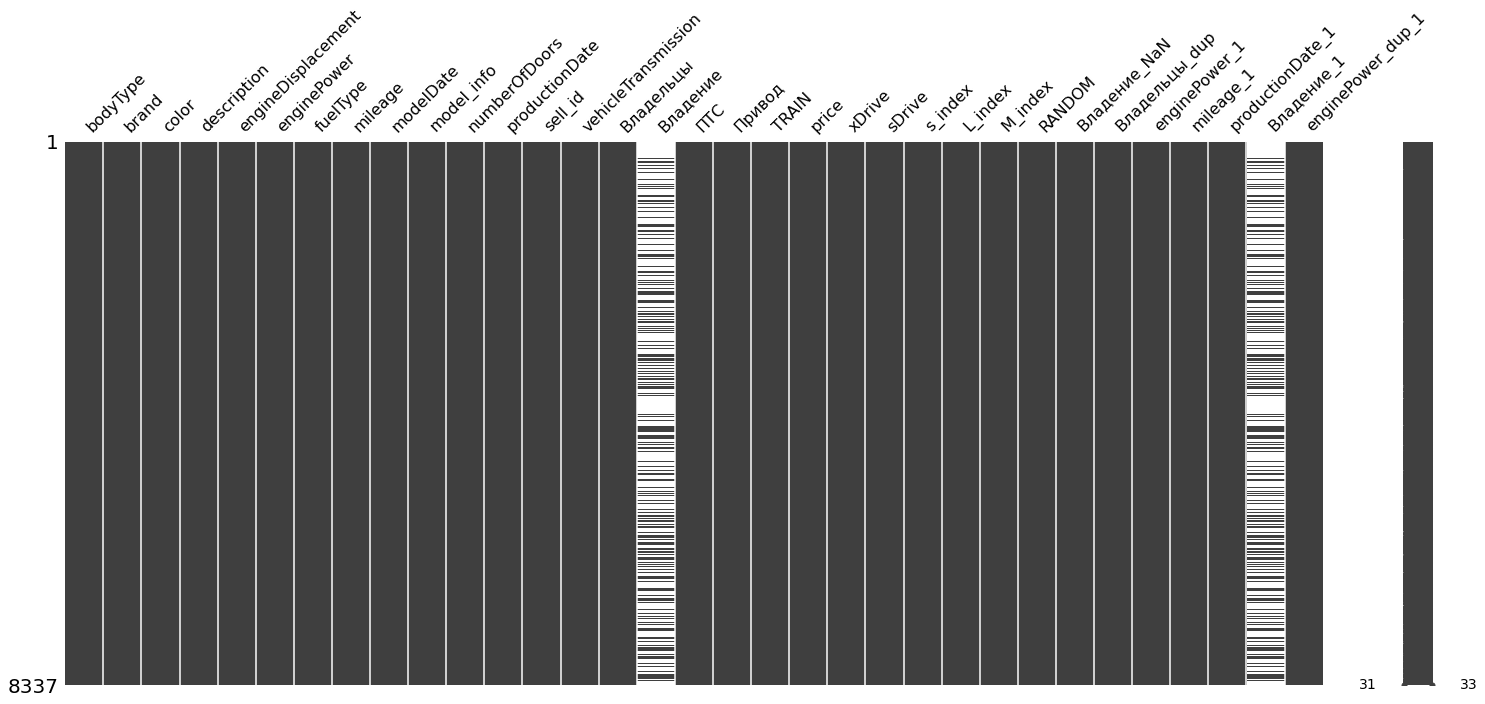

In [15]:
msno.matrix(df);

**Declare target variable, quantity, ordinal and categorical features**

In [16]:
def declare_features_type():
    """Declare target variable, quantity, ordinal and categorical features"""
    global categ_bin_cols, categ_many_cols, categ_multi_cols, categ_cols
    global quantity_cols, quantity_categ_cols, ordinal_cols, text_cols
    
    # Declare categorical features
    categ_bin_cols = [
        'xDrive',
        'sDrive',
        's_index',
        'L_index',
        'M_index',
        'ПТС',
        'Владение_NaN',
    ]
    categ_many_cols = [
        'brand',
        'model_info',
        'bodyType',
        'color',
        'fuelType',
        'vehicleTransmission',
        'Привод',
        'Владельцы'+DUPLICATE_SUFFIX,
    ]
    categ_multi_cols = [
    ]

    # Declare quantity features
    quantity_cols = [
        RANDOM,
        IDENT,
        'numberOfDoors',
        'productionDate',
        'engineDisplacement',
        'enginePower',
        'mileage',
        'Владельцы',
        'Владение',
        'modelDate',

        'productionDate'+MINUS_ONE_SUFFIX,
        'enginePower'+MINUS_ONE_SUFFIX,
        'enginePower'+DUPLICATE_SUFFIX+MINUS_ONE_SUFFIX,
        'mileage'+MINUS_ONE_SUFFIX,
        'Владение'+MINUS_ONE_SUFFIX,
    ]

    # Declare categorized quantity features
    quantity_categ_cols = [
    ]

    # Declare ordinal features
    ordinal_cols = [
    ]

    # Declare text features
    text_cols = [
        'description',
    ]

    # Update feature lists
    categ_bin_cols = [col for col in categ_bin_cols if col in df.columns]
    categ_many_cols = [col for col in categ_many_cols if col in df.columns]
    categ_multi_cols = [col for col in categ_multi_cols if col in df.columns]
    categ_cols = categ_bin_cols + categ_many_cols + categ_multi_cols
    quantity_cols = [col for col in quantity_cols if col in df.columns]
    quantity_categ_cols = [col for col in quantity_categ_cols if col in df.columns]
    ordinal_cols = [col for col in ordinal_cols if col in df.columns]
    text_cols = [col for col in text_cols if col in df.columns]
    
declare_features_type()

**View unique values**

In [17]:
# Print header
print(('Test:').rjust(30) + ('Train:').rjust(8) + ('All:').rjust(8))

# Find and show number of unique values of categorical features
categorical_unique_test = {}
categorical_unique_train = {}
categorical_unique = {}
for column in categ_cols:
    # Handle categ_multi_cols features
    if column in categ_multi_cols:
        categorical_unique_test[column] = pd.Series(Counter(chain.from_iterable(df.loc[df[column].notna() & ~df[TRAIN], column].str.split('|')))).sort_values(ascending=False)
        categorical_unique_train[column] = pd.Series(Counter(chain.from_iterable(df.loc[df[column].notna() & df[TRAIN], column].str.split('|')))).sort_values(ascending=False)
        categorical_unique[column] = pd.Series(Counter(chain.from_iterable(df.loc[df[column].notna(), column].str.split('|')))).sort_values(ascending=False)

    # Handle categ_bin_cols and categ_many_cols features
    else:
        categorical_unique_test[column] = pd.Series(Counter(chain.from_iterable(df.loc[df[column].notna() & ~df[TRAIN], column].apply(lambda x: [x])))).sort_values(ascending=False)
        categorical_unique_train[column] = pd.Series(Counter(chain.from_iterable(df.loc[df[column].notna() & df[TRAIN], column].apply(lambda x: [x])))).sort_values(ascending=False)
        categorical_unique[column] = pd.Series(Counter(chain.from_iterable(df.loc[df[column].notna(), column].apply(lambda x: [x])))).sort_values(ascending=False)

    # Show result
    print((column + ':').ljust(22)
          + str(len(categorical_unique_test[column])).rjust(8)
          + str(len(categorical_unique_train[column])).rjust(8)
          + str(len(categorical_unique[column])).rjust(8))

                         Test:  Train:    All:
xDrive:                      2       2       2
sDrive:                      1       2       2
s_index:                     2       2       2
L_index:                     2       2       2
M_index:                     2       2       2
ПТС:                         2       2       2
Владение_NaN:                2       2       2
brand:                       3       3       3
model_info:                101     115     119
bodyType:                   14      14      14
color:                      15      15      15
fuelType:                    4       4       4
vehicleTransmission:         4       4       4
Привод:                      3       3       3
Владельцы_dup:               3       3       3


In [18]:
# Parameters
ALPHABET_ORDER = False

# Print header
print(('Test:').rjust(30) + ('Train:').rjust(8) + ('All:').rjust(8))

# Show unique values of categorical features
for column in categ_cols:
    print(column + ':')
    for i in categorical_unique[column].sort_index().index if ALPHABET_ORDER \
      else categorical_unique[column].index:
        print(str(i).ljust(22), end='')
        if i in categorical_unique_test[column].index:
            print(str(categorical_unique_test[column].at[i]).rjust(8), end='')
        else:
            print(str(0).rjust(8), end='')
        if i in categorical_unique_train[column].index:
            print(str(categorical_unique_train[column].at[i]).rjust(8), end='')
        else:
            print(str(0).rjust(8), end='')
        print(str(categorical_unique[column].at[i]).rjust(8))
    print()

                         Test:  Train:    All:
xDrive:
0                         1659    6603    8262
1                           12      63      75

sDrive:
0                         1671    6657    8328
1                            0       9       9

s_index:
0                         1662    6624    8286
1                            9      42      51

L_index:
0                         1637    6533    8170
1                           34     133     167

M_index:
0                         1659    6614    8273
1                           12      52      64

ПТС:
Оригинал                  1504    5956    7460
Дубликат                   167     710     877

Владение_NaN:
1                         1092    4316    5408
0                          579    2350    2929

brand:
BMW                        730    2796    3526
MERCEDES                   552    2288    2840
AUDI                       389    1582    1971

model_info:
5ER                        165     610     775
3ER               

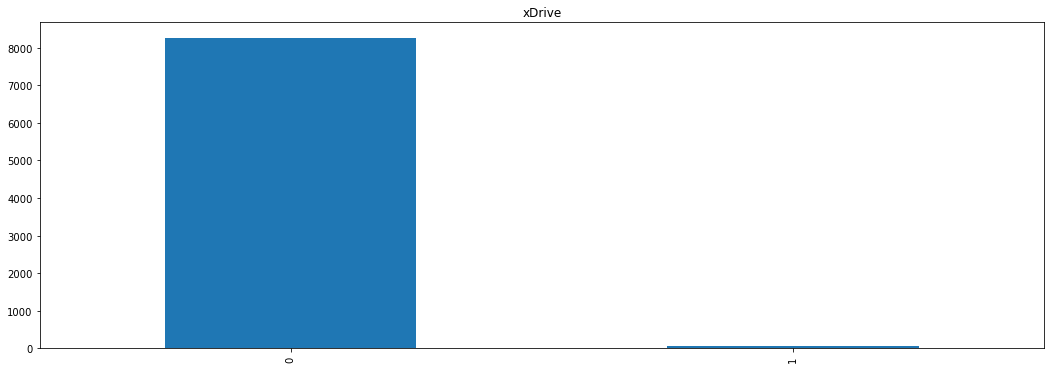

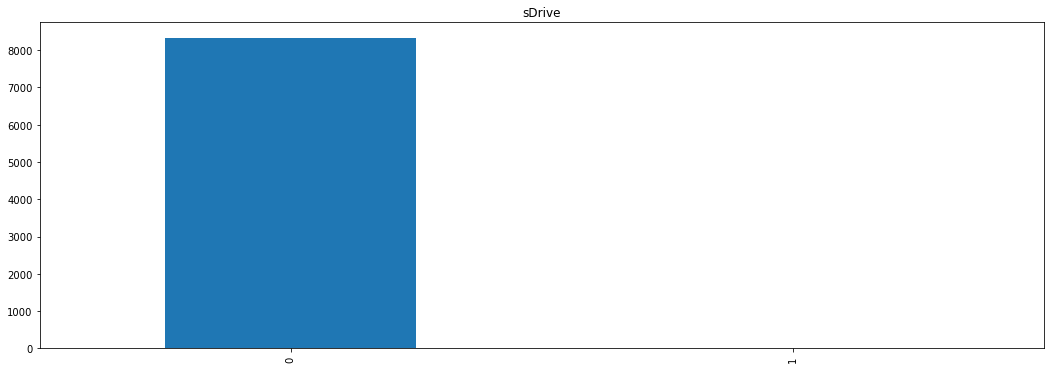

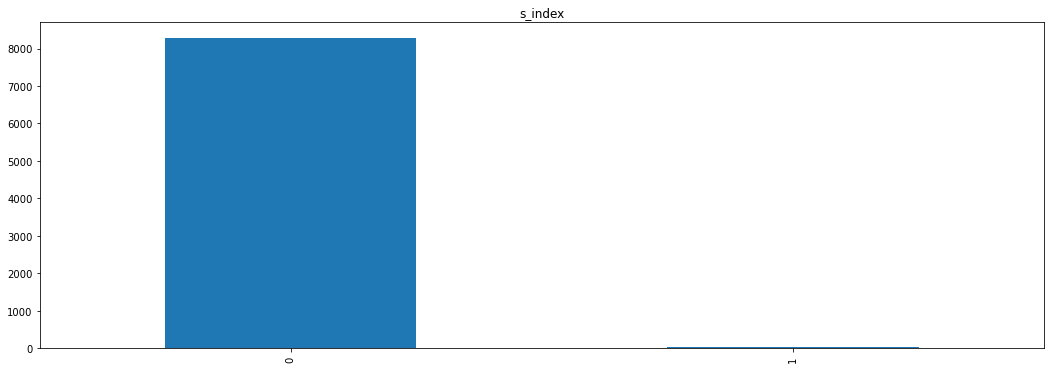

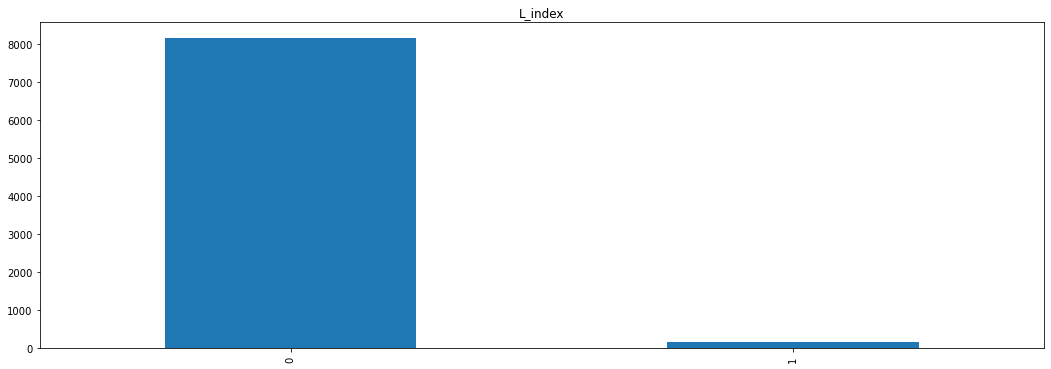

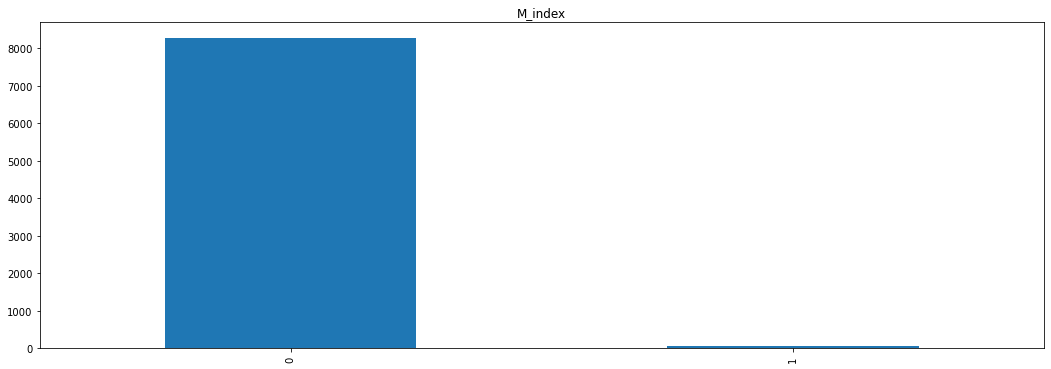

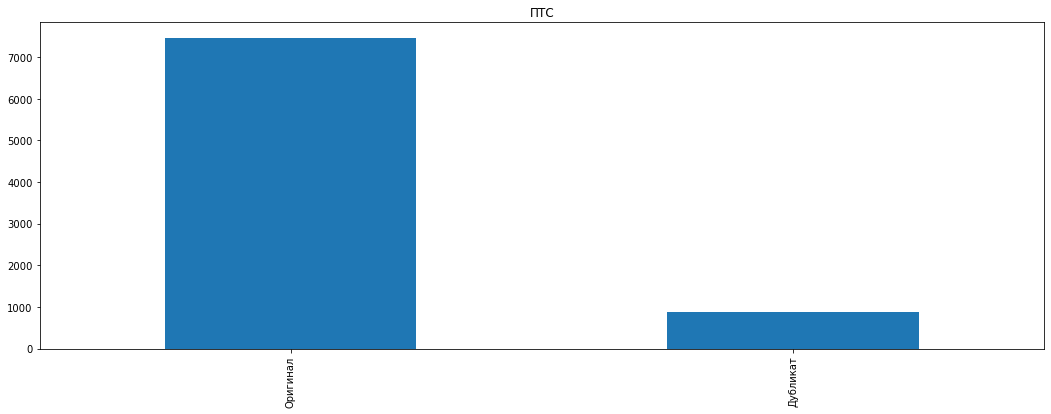

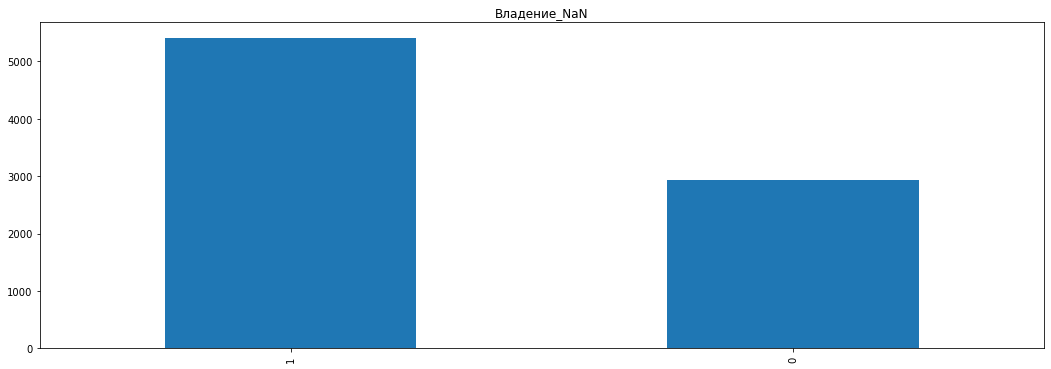

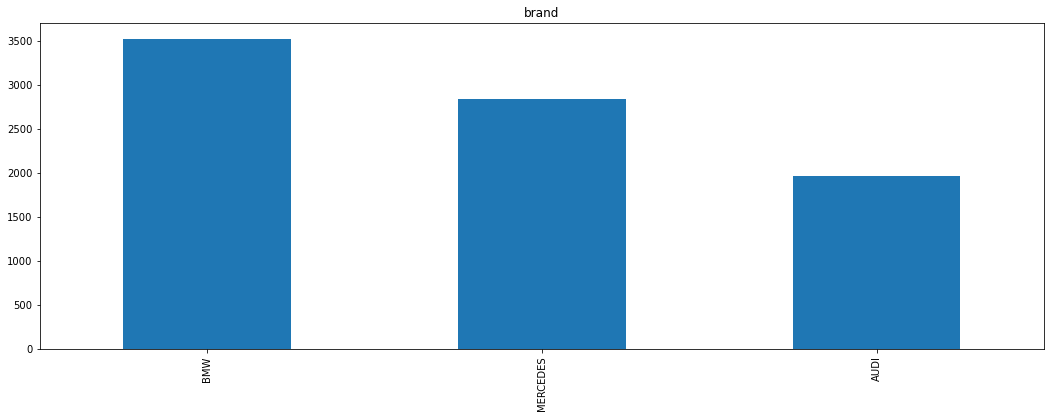

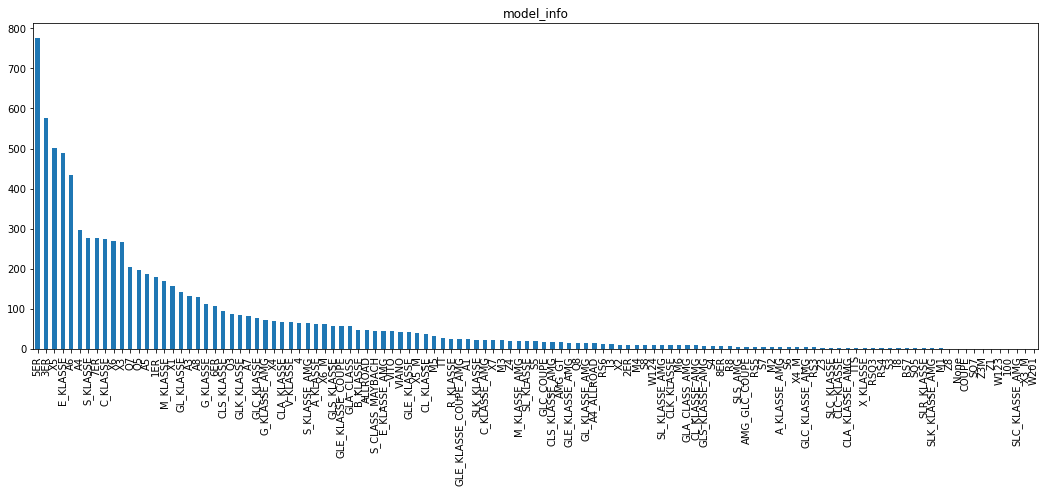

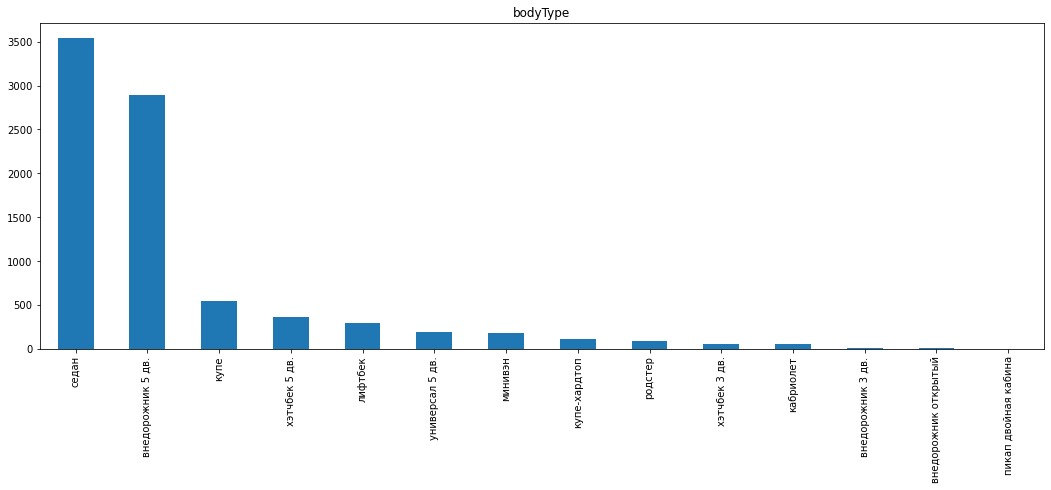

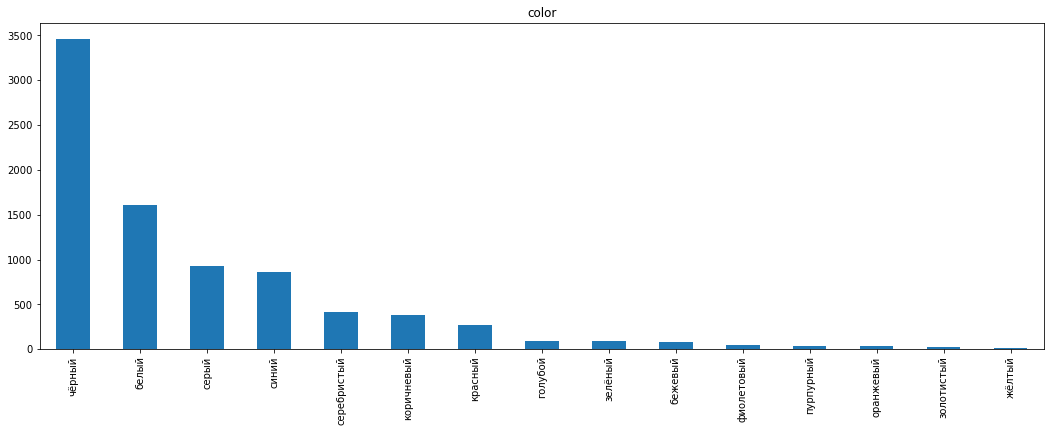

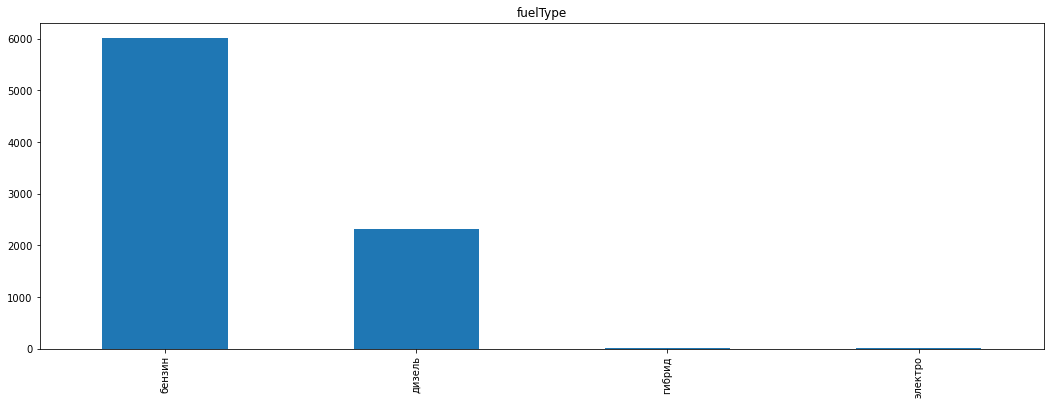

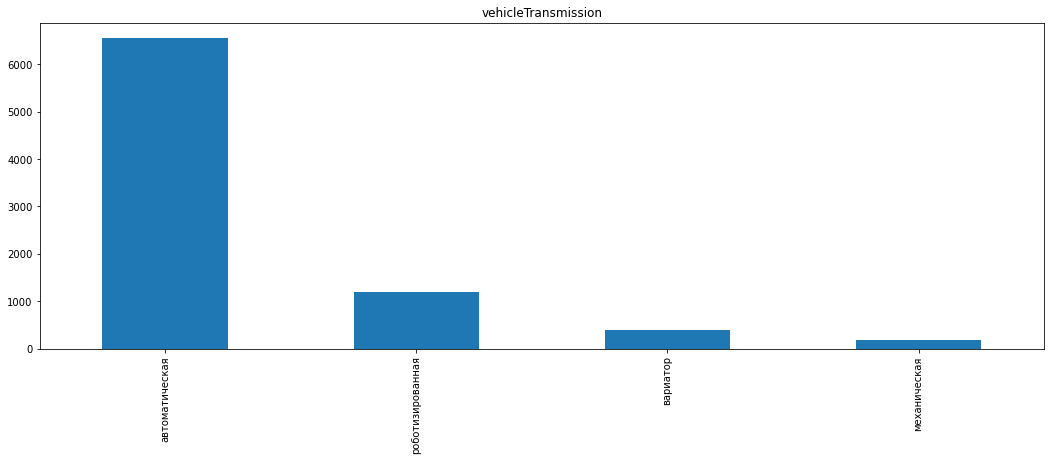

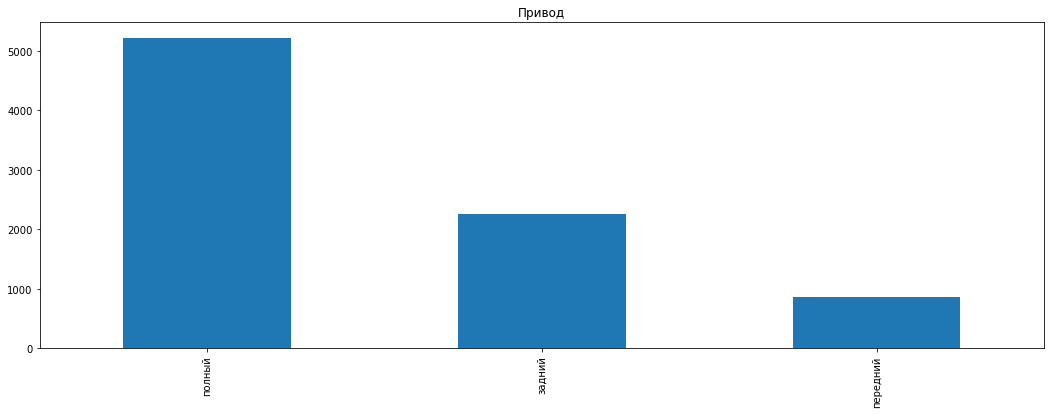

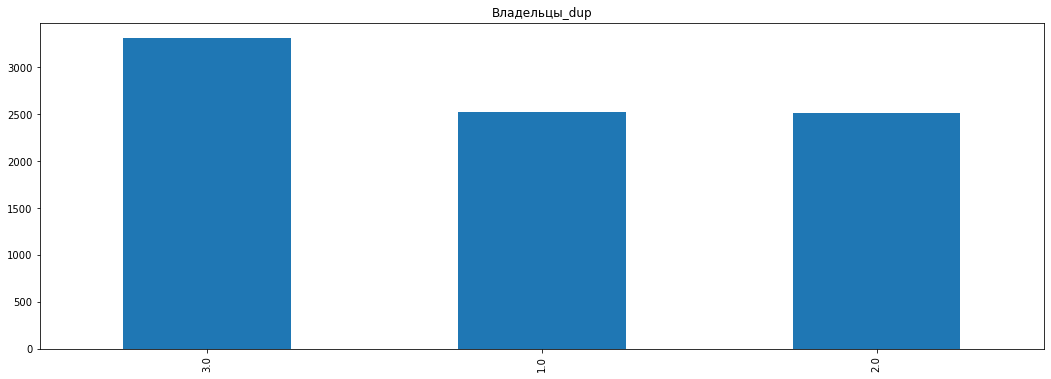

In [19]:
# Show distribution of categorical features
for column in categ_cols:
    categorical_unique[column].plot.bar(figsize=(18, 6), title=column)
    plt.show()

In [20]:
# Print header
print(('Test:').rjust(30) + ('Train:').rjust(8) + ('All:').rjust(8))

# Show number of unique values of quantity and ordinal features
for column in quantity_cols + quantity_categ_cols + ordinal_cols:
    print((column + ':').ljust(22)
          + (str(df.loc[~df[TRAIN], column].nunique()).rjust(8))
          + (str(df.loc[df[TRAIN], column].nunique()).rjust(8))
          + (str(df[column].nunique()).rjust(8)))

                         Test:  Train:    All:
RANDOM:                   1668    6642    8298
sell_id:                  1671    6666    8337
numberOfDoors:               4       4       4
productionDate:             35      38      39
engineDisplacement:         42      47      47
enginePower:               120     145     153
mileage:                   935    2895    3502
Владельцы:                   3       3       3
Владение:                  131     172     179
modelDate:                  37      40      43
productionDate_1:           35      38      39
enginePower_1:             120     145     153
enginePower_dup_1:         120     145     153
mileage_1:                 935    2895    3502
Владение_1:                131     172     179


In [21]:
# Show unique values of quantity and ordinal features
columns = [ 'numberOfDoors',
            'productionDate',
            'engineDisplacement',
            'enginePower',
            'Владельцы',
            'Владение',
            'modelDate',]

for column in quantity_cols + quantity_categ_cols + ordinal_cols:
    if column in columns:
        print(('Test:  ' + column + ':').ljust(22), end='')
        print(np.sort(df.loc[~df[TRAIN], column].unique()))
        print(('Train: ' + column + ':').ljust(22), end='')
        print(np.sort(df.loc[df[TRAIN], column].unique()))
        print(('All:   ' + column + ':').ljust(22), end='')
        print(np.sort(df[column].unique()))
        print()

Test:  numberOfDoors: [2 3 4 5]
Train: numberOfDoors: [2 3 4 5]
All:   numberOfDoors: [2 3 4 5]

Test:  productionDate:[1982 1984 1985 1986 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999
 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020]
Train: productionDate:[1982 1983 1984 1985 1986 1987 1988 1989 1990 1992 1993 1994 1995 1996
 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010
 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]
All:   productionDate:[1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995
 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009
 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]

Test:  engineDisplacement:[0.7 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8
 2.9 3.  3.1 3.2 3.5 3.6 3.7 3.8 4.  4.1 4.2 4.3 4.4 4.7 4.8 5.  5.2 5.4
 5.5 5.8 5.9 6.  6.2 6.6]
Train: engineDisplacement:[0.7 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2. 

## Visualization

In [22]:
def show_boxplots(df, show_target=False):
    """Show boxplots of quantity and ordinal features and check them for outliers existance"""
    # Define columns to plot
    if show_target:
        columns = sorted(quantity_cols + ordinal_cols + [TARGET])
    else:
        columns = sorted(quantity_cols + ordinal_cols)

    # Create figure with [rows x cols] graphs
    cols = 5
    rows = math.ceil((len(columns)) / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(18, rows*5))

    # Plot graphs
    for i, column in enumerate(columns):
        if rows == 1:
            idx = i%cols
        else:
            idx = (i//cols, i%cols)
        axs[idx].boxplot(df.loc[df[column].notna(), column], showmeans=True)
        axs[idx].set_title(column)
        

def show_histograms(df, show_target=False):
    """Show distributions of quantity and ordinal features"""
    # Parameters
    DEFAULT_BINS = 50
    
    # Fill the list of bins' step if know it
    bin_step = {
        'numberOfDoors': 1,
        'productionDate': 1,
        'Владельцы': 1,
    }
    
    # Define columns to plot
    if show_target:
        columns = sorted(quantity_cols + ordinal_cols + [TARGET])
    else:
        columns = sorted(quantity_cols + ordinal_cols)

    # Create figure with [rows x cols] graphs
    cols = 4
    rows = math.ceil(len(columns)/cols)
    fig, axs = plt.subplots(rows, cols, figsize=(18, rows*4))

    # Plot graphs
    for i, column in enumerate(columns):
        # Calculate indices of subplots
        if rows == 1:
            idx = i%cols
        else:
            idx = (i//cols, i%cols)

        # Calculate number of bins and ranges
        if column in bin_step.keys():
            col_max = df[column].max()
            col_min = df[column].min()
            step = bin_step[column]
            offset = step / 2
            bins = int((col_max-col_min) / step) + 1
            range_ = (col_min - offset, col_max + offset)
        elif column in ordinal_cols:
            col_max = df[column].max()
            col_min = df[column].min()
            bins = int((col_max-col_min) * 2) + 1
            range_ = (col_min - 0.25, col_max + 0.25)
        else:
            bins = DEFAULT_BINS
            range_ = None

        # Plot
        axs[idx].hist(df.loc[df[column].notna(), column], bins, range_)
        axs[idx].set_title(column)
        
        
def show_scatters(df, point_size=None):
    """Show scatter plots of quantity and ordinal features from TARGET"""
    # Define columns to plot
    columns = sorted(quantity_cols + ordinal_cols)

    # Create figure with [rows x cols] graphs
    cols = 4
    rows = math.ceil((len(columns)) / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(18, rows*4))

    # Plot graphs
    for i, column in enumerate(columns):
        if rows == 1:
            idx = i%cols
        else:
            idx = (i//cols, i%cols)
        axs[idx].scatter(x=df.loc[df[column].notna() & df[TRAIN], column],
                         y=df.loc[df[column].notna() & df[TRAIN], TARGET],
                         s=point_size)
        axs[idx].set_title(column)
        

def show_CQF_boxplots(df):
    """Show boxplots of categorized quantity features"""
    NUM_OF_VALS = 10
    CATEGORY = 'feature_name'

    # Create figure with [rows x cols] graphs
    rows = len(quantity_categ_cols)
    fig, axs = plt.subplots(rows, figsize=(18, rows*4))

    categ_mask = {}
    top_categ_values = {}
    for i, column in enumerate(quantity_categ_cols):
        # Find masks
        categ_mask = {}
        top_categ_values = {}
        for column in quantity_categ_cols:
            # Find top NUM_OF_VALS values categorical feature
            top_categ_values[column] = categorical_unique[CATEGORY].index[:NUM_OF_VALS]

            # Find boolean masks
            categ_mask[column] = {}
            for value in top_categ_values[column]:
                categ_mask[column][value] = df[CATEGORY].str.contains(value)

        # Plot graphs
        if rows == 1:
            axs.boxplot([df.loc[categ_mask[column][value], column] for value in top_categ_values[column]], showmeans=True)
            axs.set_title(column)
            axs.set_xticklabels(top_categ_values[column], rotation=5)
        else:
            axs[i].boxplot([df.loc[categ_mask[column][value], column] for value in top_categ_values[column]], showmeans=True)
            axs[i].set_title(column)
            axs[i].set_xticklabels(top_categ_values[column], rotation=5)
            
    return (top_categ_values, categ_mask)
            
            
def show_CQF_histograms(df, top_categ_values, categ_mask):
    """Show distributions of categorized quantity features"""
    BINS = 100

    # Create figure with [rows x cols] graphs
    rows = len(quantity_categ_cols)
    fig, axs = plt.subplots(rows, figsize=(18, rows*4))

    for i, column in enumerate(quantity_categ_cols):
        # Plot graphs
        if rows == 1:
            for value in top_categ_values[column]:
                axs.hist(df.loc[categ_mask[column][value], column], bins=BINS)
                axs.set_title(column)
        else:
            for value in top_categ_values[column]:
                axs[i].hist(df.loc[categ_mask[column][value], column], bins=BINS)
                axs[i].set_title(column)

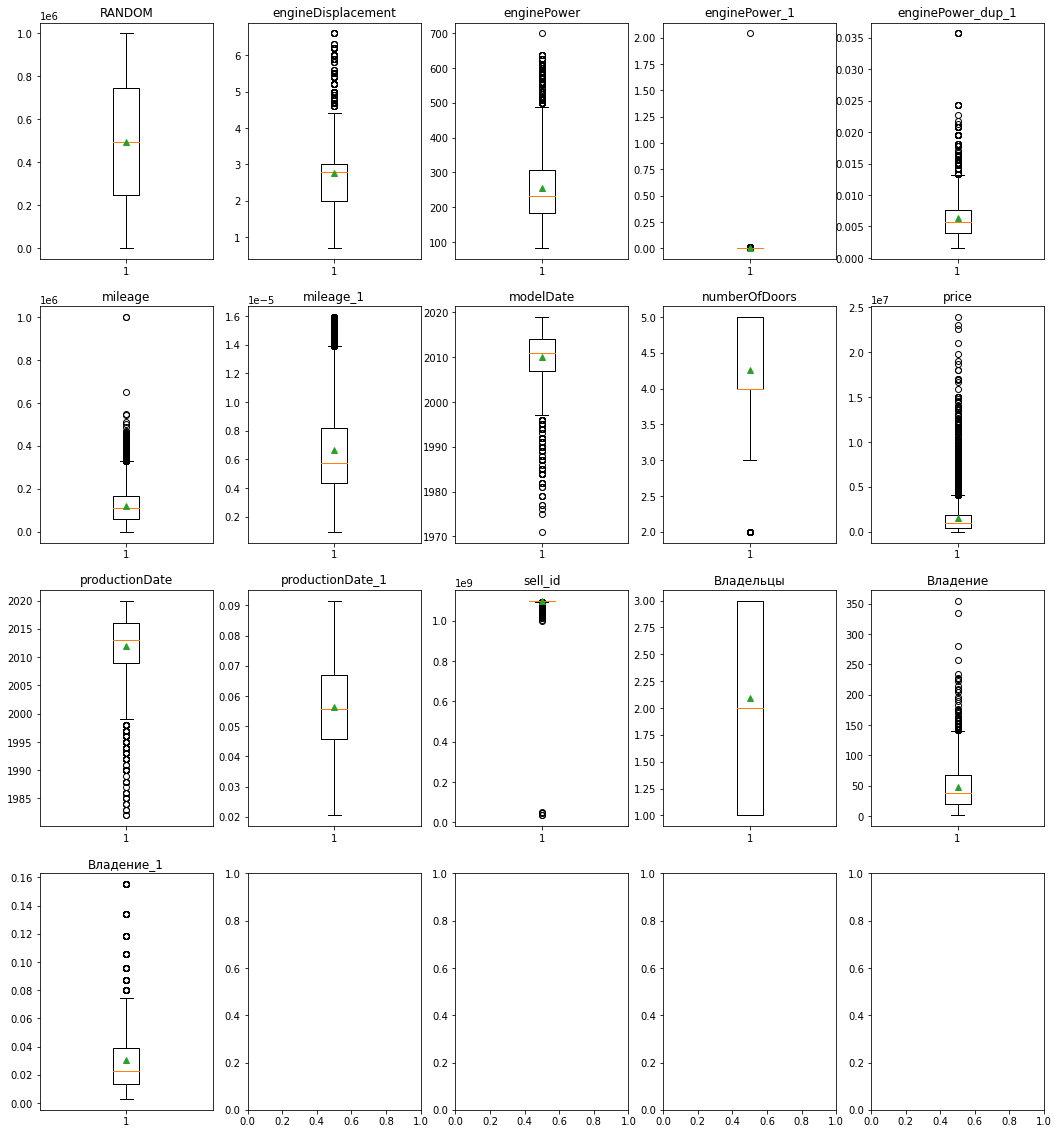

In [23]:
show_boxplots(df, show_target=True)

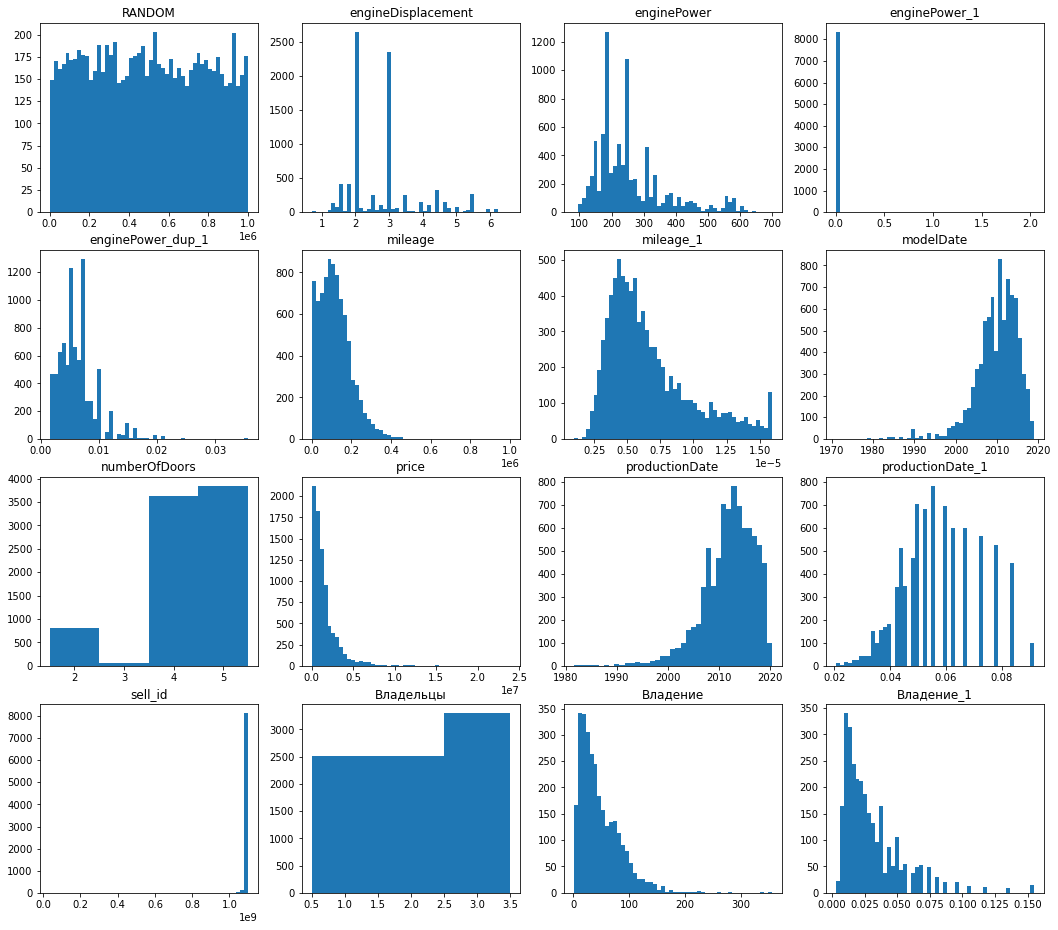

In [24]:
show_histograms(df, show_target=True)

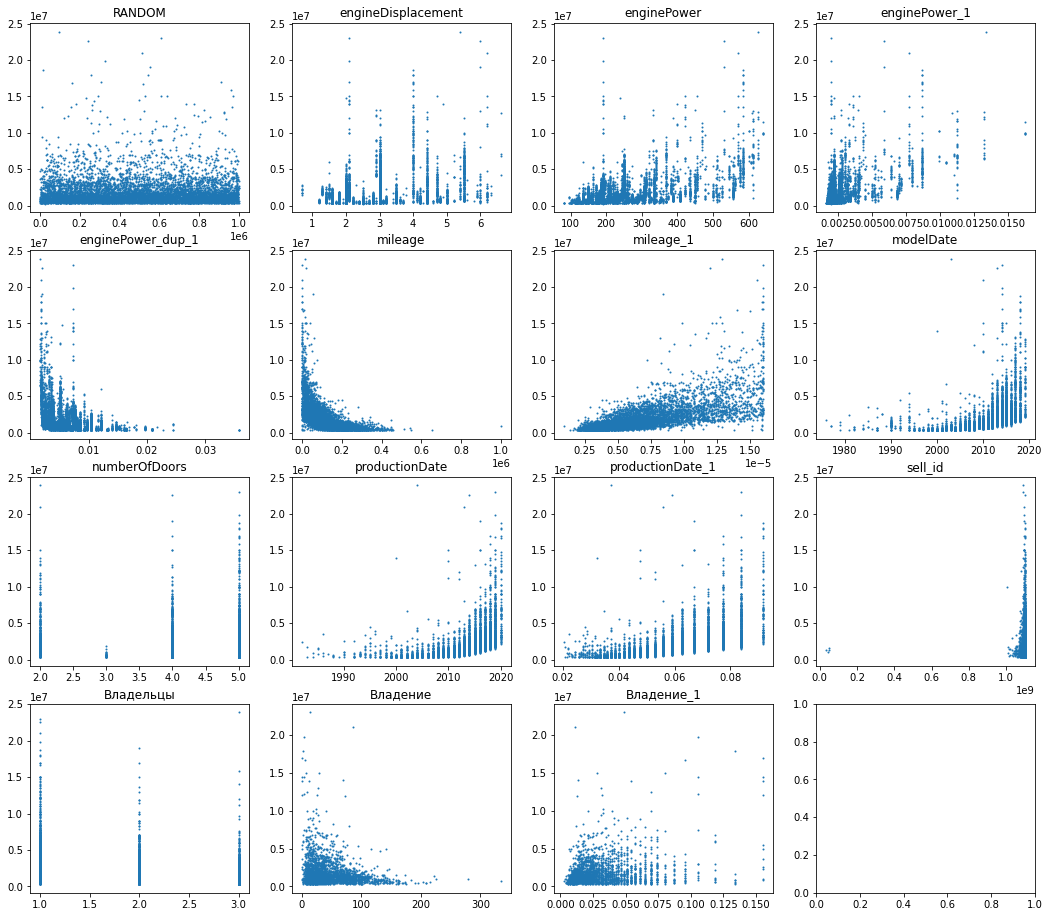

In [25]:
show_scatters(df, point_size=1)

In [26]:
# top_categ_values, categ_mask = show_CQF_boxplots(df)

In [27]:
# show_CQF_histograms(df, top_categ_values, categ_mask)

## Outliers handling

In [28]:
def delete_outliers(df, inplace=False):
    """Show number of outliers and delete rows with outliers"""
    # Define columns to show graphs
    columns = sorted(quantity_cols).copy()
    
    # Exclude some columns from the process
    cols = [

    ]
    for col in df.columns:
        if col in cols:
            columns.remove(col)
    
    idx_dict = {}
    for column in columns:
        # Calculate Q1, Q3, IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Calculate indices of rows
        idx_dict[column] = list(df.loc[(~df[column].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)) & (df[column].notna()), column].index)

        # Show the result
        outliers_num = len(idx_dict[column])
        if outliers_num:
            print(f"{str(outliers_num).rjust(6)} outliers are in column '{column}'")
            
    # Union indices
    idx = set()
    for column in columns:
        idx.update(idx_dict[column])

    # Drop rows with outliers
    if inplace:
        df.drop(idx, inplace=True)
        print(f"{str(len(idx)).rjust(6)} rows have been dropped")

In [29]:
# Show or delete outliers
print('train:')
delete_outliers(df.loc[df[TRAIN]], inplace=DROP_TEST_ROWS)
print('test:')
delete_outliers(df.loc[~df[TRAIN]], inplace=DROP_TEST_ROWS)
print('join:')
delete_outliers(df, inplace=DROP_TEST_ROWS)

train:
   560 outliers are in column 'engineDisplacement'
   401 outliers are in column 'enginePower'
   638 outliers are in column 'enginePower_1'
   261 outliers are in column 'enginePower_dup_1'
   115 outliers are in column 'mileage'
   300 outliers are in column 'mileage_1'
   141 outliers are in column 'modelDate'
   625 outliers are in column 'numberOfDoors'
   104 outliers are in column 'productionDate'
   722 outliers are in column 'sell_id'
    53 outliers are in column 'Владение'
    92 outliers are in column 'Владение_1'
test:
   128 outliers are in column 'engineDisplacement'
    91 outliers are in column 'enginePower'
   157 outliers are in column 'enginePower_1'
    58 outliers are in column 'enginePower_dup_1'
    37 outliers are in column 'mileage'
    75 outliers are in column 'mileage_1'
    48 outliers are in column 'modelDate'
   175 outliers are in column 'numberOfDoors'
    38 outliers are in column 'productionDate'
   160 outliers are in column 'sell_id'
    10 

## Missing values handling

In [30]:
def fill_missing_values(df):
    """Fill missing values (NaNs) for columns"""
    # Drop rows with missing values of target variable
    nan_number = df[TARGET].isna().sum()
    if nan_number:
        df.dropna(subset=[TARGET], inplace=True)
        print(f"{nan_number} rows have been dropped in order to delete missed target values")

    # Drop rows with missing values
    pass
    
    # Fill missing values
    for column in quantity_cols + ordinal_cols + categ_cols:
        # Calculate number of replaced values
        nan_number = df[column].isna().sum()
        
        if nan_number:
            # For individual columns
            if column == 'column_name':
                value = 2
                
            elif column == 'column_2':
                values = df.groupby('categ_column')['column_2'].mean().round()
                df['zzz'] = df['categ_column'].map(values)
                idx = df['column_2'].isna()
                df.loc[idx, 'column_2'] = df.loc[idx, 'zzz']
                df.drop('zzz', axis=1, inplace=True)
                continue

            # For groups of columns
            elif column in quantity_cols:
                value = df[column].mean()
#                 value = df[column].median()
#                 value = df[column].mode()[0]

            elif column in ordinal_cols:
#                 value = df[column].mean()
#                 value = df[column].median()
                value = df[column].mode()[0]

            elif column in categ_bin_cols:
#                 continue
                value = categorical_unique[column].index[0]

            elif column in categ_many_cols:
#                 continue
                value = categorical_unique[column].index[0]

            elif column in categ_multi_cols:
#                 continue
#                 value = categorical_unique[column].index[0]
                values_num = round(df.loc[df[column].notna(), column].apply(lambda x: len(x.split('|'))).mean())
                value = '|'.join(categorical_unique[column].index[:values_num])

            # Replace
            df[column].fillna(value, inplace=True)
            
            # Show number of replaced values in column
            print(f"{str(nan_number).rjust(6)} NaN have been replaced in column '{column}'")

In [31]:
# Fill missing values
fill_missing_values(df)

     1 NaN have been replaced in column 'Владельцы'
  5408 NaN have been replaced in column 'Владение'
  5408 NaN have been replaced in column 'Владение_1'
     1 NaN have been replaced in column 'Владельцы_dup'


## Form -1 degree features
### Distribution optimization is based on ANOVA analysis

In [32]:
def anova_analysis(df):
    """Calculate and show significance of quantity and ordinal features based on ANOVA analysis"""
    columns = quantity_cols + ordinal_cols
    df_temp = df.loc[df[TRAIN], columns + [TARGET]].dropna()
    return pd.Series(f_classif(df_temp[columns], df_temp[TARGET])[0], index=columns)


def calc_anova_optimum_distribution(df, columns):
    """Find best distribution parameters with help of ANOVA
    
    columns - column names with existing of MINUS_ONE_SUFFIX.
    """
    # Parameters
    START = 0.0001 # Parts of median
    STOP = 10     # Parts of median
    POINTS = 50   # Number of points between START and STOP

    # Reset columns' values
    df_temp = pd.DataFrame()
    for column in columns:
        df_temp[column+MINUS_ONE_SUFFIX] = df[column+MINUS_ONE_SUFFIX].copy()
        df[column+MINUS_ONE_SUFFIX] = 1 / (df[column] - df[column].min() + abs(df[column].median()))

    # Cycle over columns
    param_dict = {}
    result_dict = {}
    for column in columns:
        # Cycle over distribution adders
        max_anova = 0
        param_dict[column+MINUS_ONE_SUFFIX+'_adder'] = []
        param_dict[column+MINUS_ONE_SUFFIX+'_min'] = []
        param_dict[column+MINUS_ONE_SUFFIX+'_max'] = []
        for i in np.geomspace(start=START, stop=STOP, num=POINTS):
            # Calc and save adder
            adder = i*abs(df[column].median())
            param_dict[column+MINUS_ONE_SUFFIX+'_adder'].append(adder)

            for minmax in ['_min', '_max']:
                # Calc and save ANOVA with 'min' and 'max'
                if minmax == '_min':
                    df[column+MINUS_ONE_SUFFIX] = 1 / (df[column] - df[column].min() + adder)
                elif minmax == '_max':
                    df[column+MINUS_ONE_SUFFIX] = 1 / (df[column].max() - df[column] + adder)
                anova = anova_analysis(df)[column+MINUS_ONE_SUFFIX]
                param_dict[column+MINUS_ONE_SUFFIX+minmax].append(anova)

                # Update best result
                if anova > max_anova:
                    max_anova = anova.copy()
                    result_dict[column+MINUS_ONE_SUFFIX] = (minmax, adder)

            # Reset column+MINUS_ONE_SUFFIX values
            df[column+MINUS_ONE_SUFFIX] = 1 / (df[column] - df[column].min() + abs(df[column].median()))

    # Print result optimum parameters
    pprint(result_dict)
    
    result_df = pd.DataFrame(param_dict)
    for column in columns:
        # Restore columns' values
        df[column+MINUS_ONE_SUFFIX] = df_temp[column+MINUS_ONE_SUFFIX].copy()
        
        # Plot graphs
        result_df.plot(y=[column+MINUS_ONE_SUFFIX+'_min', column+MINUS_ONE_SUFFIX+'_max']);
        plt.show()

    return result_dict, result_df

In [33]:
# Calculate best distribution parameters
columns = ['productionDate', 'enginePower', 'mileage', 'Владение']
# calc_anova_optimum_distribution(df, columns)[1]

In [34]:
# Form -1 degree features
distr_params = { 'enginePower_1': ('_max', 0.489939655109564),
                 'mileage_1': ('_min', 6.270772e+04),
                 'productionDate_1': ('_max', 10.917066308480281),
                 'Владение_1': ('_min', 6.447245)}
create_degree_1_features(df, distr_params)

# Additional -1 degree feature with second extremum parameters
df['enginePower_dup_1'] = 1 / (df['enginePower'] - df['enginePower'].min() + 21.027888)

## Polynomial features generation

In [35]:
def generate_polynomials(df, columns, collinear_sens=False):
    """Generate polynomial features
    
    collinear_sens is parameter for ML model collinearity sensitivity.
    It's either True or False. It should be True for OLS method for example.
    """
    global quantity_cols
    
    # Generate polynomials for quantity_cols
    pf = PolynomialFeatures(2, interaction_only=collinear_sens)
    pf_df = pf.fit_transform(df[columns])
    pf_cols = pf.get_feature_names(input_features=columns)
    
    # Find columns of ones
    columns_1 = []
    for column in columns:
        columns_1.append(column + ' ' + column + MINUS_ONE_SUFFIX)
        columns_1.append(column + MINUS_ONE_SUFFIX + ' ' + column)
    columns_1 = [x for x in columns_1 if x in pf_cols]
    
    # Join dataframe and drop duplicated columns and ones
    pf_df = pd.DataFrame(pf_df, columns=pf_cols, index=df.index).drop(columns=columns+['1']+columns_1)
    df = pd.concat([df, pf_df], axis=1)
    
    # Add columns to quantity_cols list
    quantity_cols = list(set(quantity_cols + pf_cols) - set(columns_1 + ['1']))
    
    return df

In [36]:
columns = list(set(quantity_cols) - set([
    RANDOM, IDENT, 'numberOfDoors', 'engineDisplacement', 'Владельцы',
]))

# Generate polynomial features
df = generate_polynomials(df, columns, collinear_sens=False)

## Distributrion normalization
### Distribution normalization based on log function

In [37]:
def normalize_distribution(df, columns, show_result=False):
    """Find best parameters of distribution normalization based on log function"""
    # Normalize distribution
    for column in columns:
        df.loc[df[column].notna(), column] = df.loc[df[column].notna(), column].apply(lambda x: np.log1p(x))
    
    # Show graphs
    if show_result:
        cols = 4
        rows = math.ceil(len(columns)/cols)
        fig, axs = plt.subplots(rows, cols, figsize=(18, rows*4))
        for i, column in enumerate(columns):
            idx = i%cols if rows == 1 else (i//cols, i%cols) # Plot indices
            axs[idx].hist(df.loc[df[column].notna(), column])
            axs[idx].set_title(column)

In [38]:
# Define columns to normalize
columns = [
    'productionDate',
    'enginePower',
    'mileage',
    'Владение',
]
    
# Normalize distribution
# normalize_distribution(df, columns, show_result=True)

## Significance analysis of features
### Analysis of quantity and ordinal features
#### Correlation analysis

In [39]:
# Calculate correlation matrix
corr_table = df.loc[df[TRAIN]].drop(TRAIN, axis=1).corr()
corr_table

,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,sell_id,Владельцы,Владение,price,xDrive,sDrive,s_index,L_index,M_index,RANDOM,Владение_NaN,Владельцы_dup,enginePower_1,mileage_1,...,mileage^2,mileage productionDate_1,mileage Владение,mileage productionDate,mileage enginePower_dup_1,mileage enginePower_1,productionDate_1^2,productionDate_1 Владение,productionDate_1 enginePower_dup_1,productionDate_1 enginePower_1,Владение^2,Владение productionDate,Владение enginePower_dup_1,Владение enginePower_1,productionDate^2,productionDate enginePower_dup_1,productionDate enginePower_1,enginePower_dup_1^2,enginePower_dup_1 enginePower_1,enginePower_1^2
engineDisplacement,1.000000,0.861266,0.052215,-0.193334,-0.004281,-0.208104,-0.007414,0.124682,0.074770,0.287578,-0.000404,-0.042547,0.053207,0.124656,0.059402,0.016587,-0.000331,0.124889,0.666220,-0.016266,...,0.056625,-0.031254,0.069915,0.051492,-0.284251,0.426033,-0.177282,-0.037815,-0.734943,0.476927,0.066739,0.073779,-0.459317,0.576449,-0.208137,-0.687048,0.664445,-0.422998,-0.478463,0.501271
enginePower,0.861266,1.000000,-0.186397,0.103191,-0.030180,0.086873,-0.002145,-0.012918,0.002896,0.490813,-0.014872,-0.037594,0.030974,0.116896,0.131812,0.015970,0.010204,-0.012761,0.866343,0.210717,...,-0.134522,-0.212309,-0.122952,-0.186688,-0.440417,0.242993,0.084510,0.052298,-0.712730,0.755655,-0.003829,0.003387,-0.541075,0.672250,0.086876,-0.761113,0.865810,-0.480536,-0.473048,0.710678
mileage,0.052215,-0.186397,1.000000,-0.684546,0.045281,-0.714266,-0.002803,0.450892,0.142580,-0.539426,0.093023,-0.039273,0.097277,-0.004334,-0.062299,0.008749,-0.017392,0.450931,-0.217209,-0.861849,...,0.895514,0.929745,0.765358,0.999992,0.683291,0.847962,-0.720380,-0.267218,-0.208575,-0.402857,0.118382,0.139185,0.159896,-0.080715,-0.714796,0.119700,-0.219789,0.114051,0.041338,-0.202417
modelDate,-0.193334,0.103191,-0.684546,1.000000,0.091320,0.963631,0.030528,-0.476969,-0.206391,0.490471,-0.092885,0.041057,-0.080569,0.016416,0.072593,0.001765,0.041420,-0.477267,0.138221,0.627628,...,-0.566257,-0.457988,-0.548994,-0.682637,-0.483255,-0.591376,0.837642,0.320859,0.300279,0.388334,-0.219457,-0.201349,-0.196948,-0.018660,0.963543,-0.104152,0.141899,-0.123494,-0.061118,0.141116
numberOfDoors,-0.004281,-0.030180,0.045281,0.091320,1.000000,0.104702,0.020181,-0.107327,-0.002616,0.014985,-0.049277,0.030619,0.059834,-0.043618,0.031131,0.013159,0.042552,-0.107367,-0.038463,-0.050709,...,0.020247,0.092475,0.032402,0.045853,0.012357,0.050266,0.074192,0.053174,0.051614,-0.003204,-0.015040,-0.001977,0.008829,-0.033211,0.104588,0.015781,-0.037966,0.021102,-0.000111,-0.033789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
productionDate enginePower_dup_1,-0.687048,-0.761113,0.119700,-0.104152,0.015781,-0.077722,0.004584,0.021571,0.002025,-0.341812,-0.025260,0.055390,-0.051623,-0.102993,-0.090649,-0.013048,-0.005182,0.021421,-0.488612,-0.124437,...,0.103170,0.122806,0.073291,0.119734,0.654380,-0.183119,-0.071154,-0.038781,0.876095,-0.415300,0.008113,0.001606,0.725415,-0.383543,-0.077676,1.000000,-0.488207,0.889912,0.917729,-0.348676
productionDate enginePower_1,0.664445,0.865810,-0.219789,0.141899,-0.037966,0.136101,0.003885,-0.045897,-0.015985,0.530327,-0.025715,-0.018718,-0.003415,0.058599,0.089547,0.016602,0.013183,-0.045854,0.999991,0.266317,...,-0.146754,-0.244337,-0.152793,-0.220136,-0.294561,0.161792,0.150419,0.067610,-0.449919,0.935182,-0.018365,-0.015292,-0.349117,0.743918,0.136220,-0.488207,1.000000,-0.267000,-0.101455,0.957462
enginePower_dup_1^2,-0.422998,-0.480536,0.114051,-0.123494,0.021102,-0.095596,0.004106,0.040217,0.008885,-0.220088,-0.026589,0.038114,-0.034876,-0.062749,-0.048822,-0.012958,-0.003458,0.040128,-0.267112,-0.097348,...,0.122190,0.098033,0.066289,0.113912,0.712165,-0.081773,-0.084490,-0.039995,0.718156,-0.233894,0.012266,0.008398,0.645887,-0.207317,-

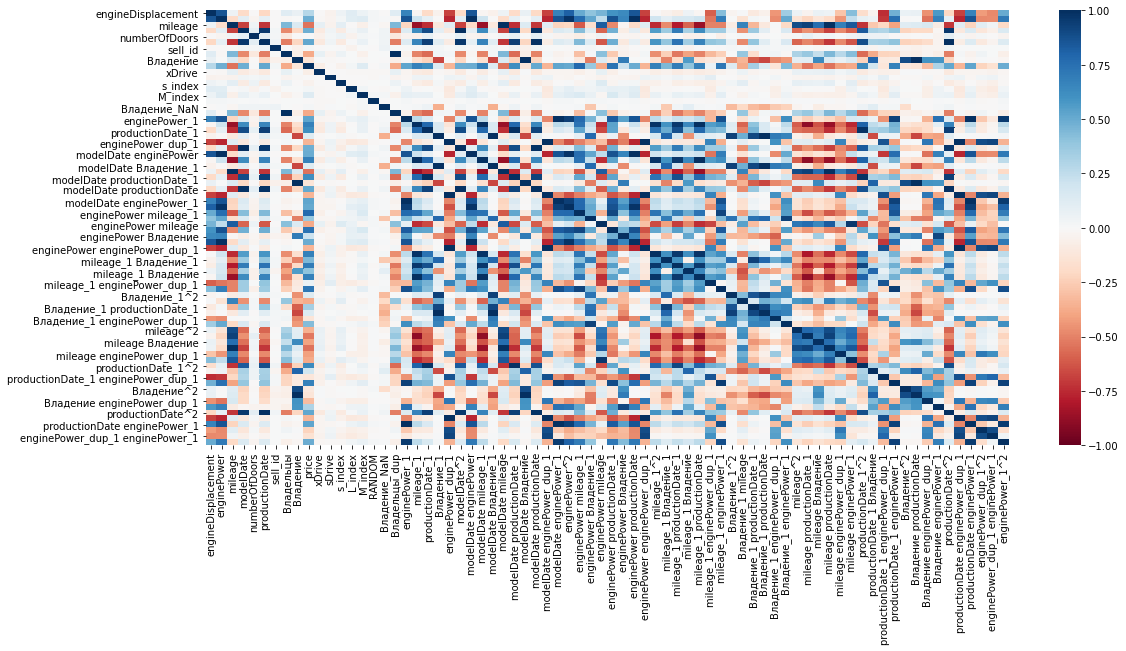

In [40]:
# Show correlation matrix
plt.subplots(figsize=(18, 8))
sns.heatmap(corr_table, vmin=-1, vmax=1, cmap="RdBu");

In [41]:
# Sort absolute correlation values with target variable
corr_table[TARGET].abs().sort_values(ascending=False)

price                           1.000000
enginePower mileage_1           0.786775
enginePower productionDate_1    0.736886
mileage_1 enginePower_1         0.719433
mileage_1 productionDate_1      0.696489
                                  ...   
sell_id                         0.024395
Владение_NaN                    0.018238
numberOfDoors                   0.014985
RANDOM                          0.005284
sDrive                          0.003625
Name: price, Length: 74, dtype: float64

#### Analysis of variance (ANOVA)

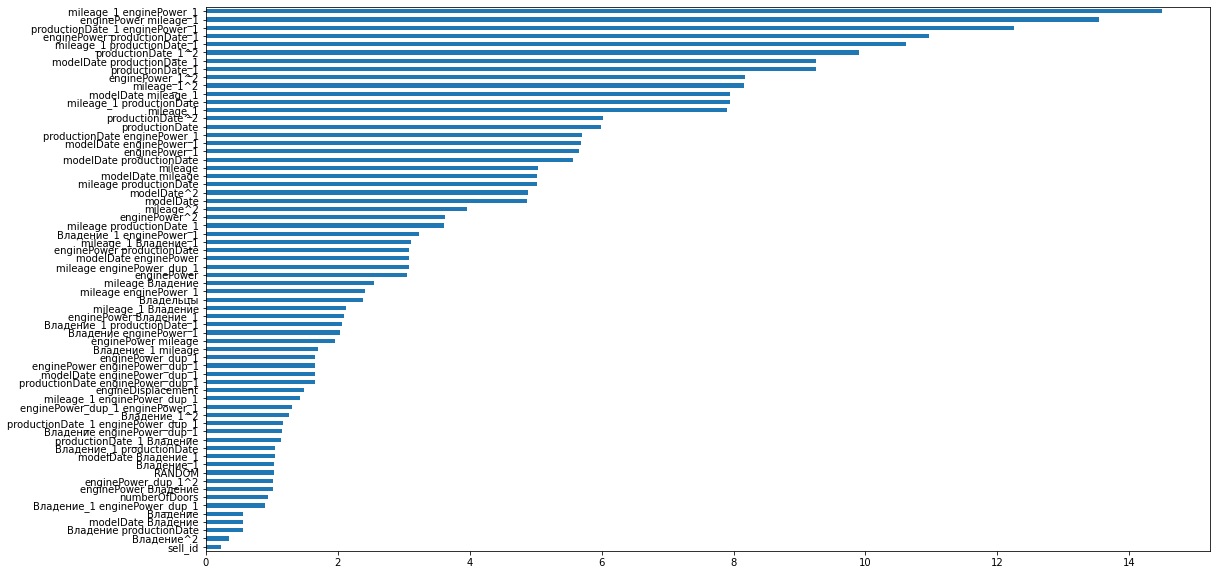

In [42]:
# Do ANOVA analysis
anova_analysis(df).sort_values().plot(figsize=(18, 10), kind='barh');

### Significance analysis of categorical features
#### Student's t-test

Using the Student's test, we will check whether there is a statistically significant difference in the distribution of the target variable for different values of categorical features. We test the null hypothesis that the distributions of the target variable over different values of the categorical variables are indistinguishable.

In [43]:
def hypothesis_testing(df):
    """Hypothesis testing of significance analysis"""
    NUM_OF_VALS = 10

    # Find not significant features
    mask = {}
    top_values = {}
    not_signif_columns = []
    for column in categ_cols:
        # Find top NUM_OF_VALS values
        top_values[column] = categorical_unique[column].index[:NUM_OF_VALS]

        # Find boolean masks
        mask[column] = {}
        for value in top_values[column]:
            if column in categ_multi_cols:
                mask[column][value] = (df[column].str.contains('(?:^|\|)'+value+'(?:$|\|)')) & (df[TARGET].notna())
            else:
                mask[column][value] = (df[column] == value) & (df[TARGET].notna())

        # Student t-test for value combinations
        combs = list(combinations(top_values[column], 2))
        for comb in combs:
            if ttest_ind(df.loc[mask[column][comb[0]], TARGET], 
                         df.loc[mask[column][comb[1]], TARGET]) \
                            .pvalue <= 0.05/len(combs): # Bonferroni correction
                break
        else:
            not_signif_columns.append(column)

    # Show result
    if len(not_signif_columns):
        print('Statistically significant differences have NOT been found for features:')
        for column in not_signif_columns:
            print(f"'{column}'")
    else:
        print('All categorical features have statistically significant difference with target')
        
    return (top_values, mask)


def boxplot_significance(df, top_values, mask):
    """Show boxplots of features to view significance"""
    # Create figure with [rows x cols] graphs
    rows = len(categ_cols)
    fig, axs = plt.subplots(rows, figsize=(18, rows*4))

    # Plot graphs
    for i, column in enumerate(categ_cols):
        if rows == 1:
            axs.boxplot([df.loc[mask[column][value], TARGET] for value in top_values[column]], showmeans=True)
            axs.set_title(column)
            axs.set_xticklabels(top_values[column], rotation=5)
            axs.set_ylabel(TARGET)
        else:
            axs[i].boxplot([df.loc[mask[column][value], TARGET] for value in top_values[column]], showmeans=True)
            axs[i].set_title(column)
            axs[i].set_xticklabels(top_values[column], rotation=5)
            axs[i].set_ylabel(TARGET)

Statistically significant differences have NOT been found for features:
'sDrive'
'Владение_NaN'


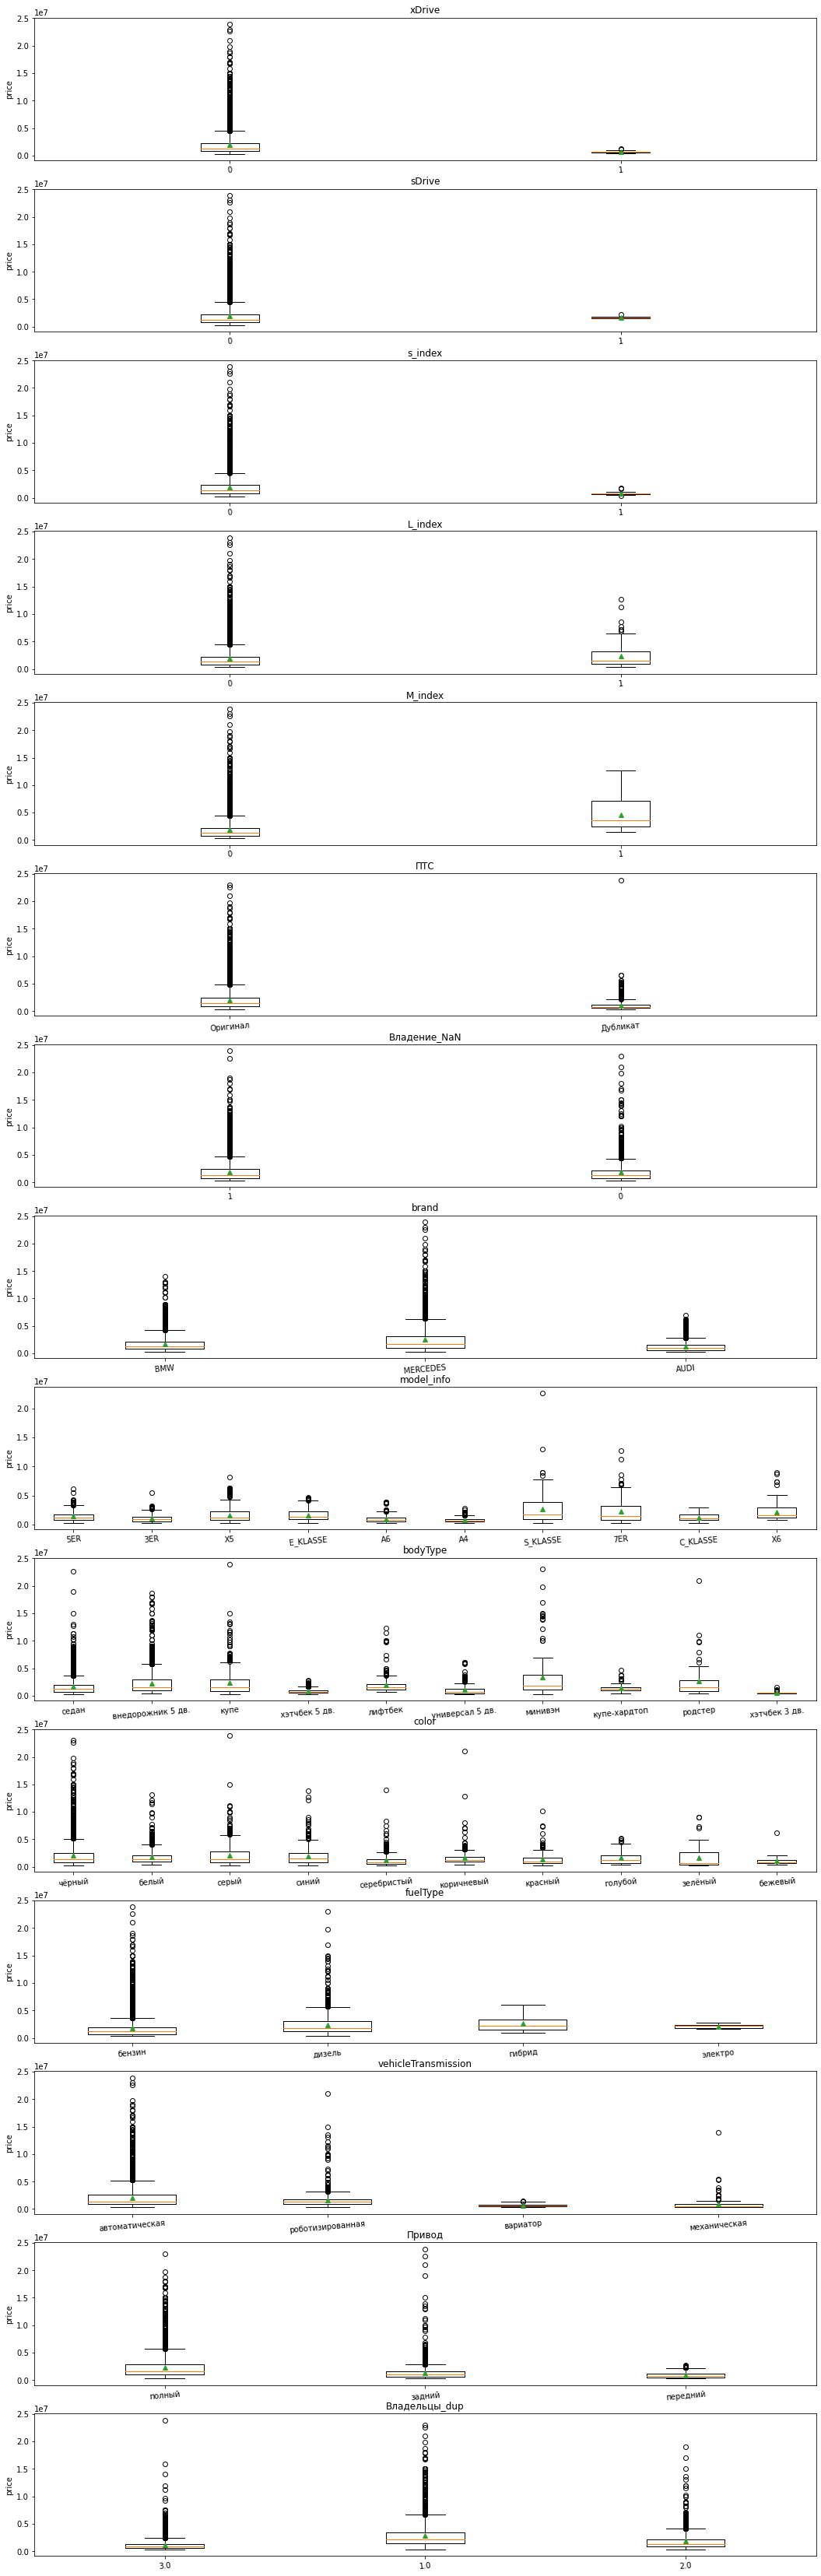

In [44]:
# Do hypothesis testing and show boxplots of significant features
top_values, mask = hypothesis_testing(df.loc[df[TRAIN]])
boxplot_significance(df.loc[df[TRAIN]], top_values, mask)

#### Mutual information

In [45]:
def mutual_information_analysis(df):
    """Calculate and show significance of categorical features based on mutual information analysis"""
    columns = categ_bin_cols + categ_many_cols
    df_temp = df[columns + [TARGET]].dropna()
    pd.Series(mutual_info_classif(OrdinalEncoder().fit_transform(df_temp[columns]), df_temp[TARGET], discrete_features=True), index=columns).sort_values().plot(figsize=(18, 6), kind='barh');

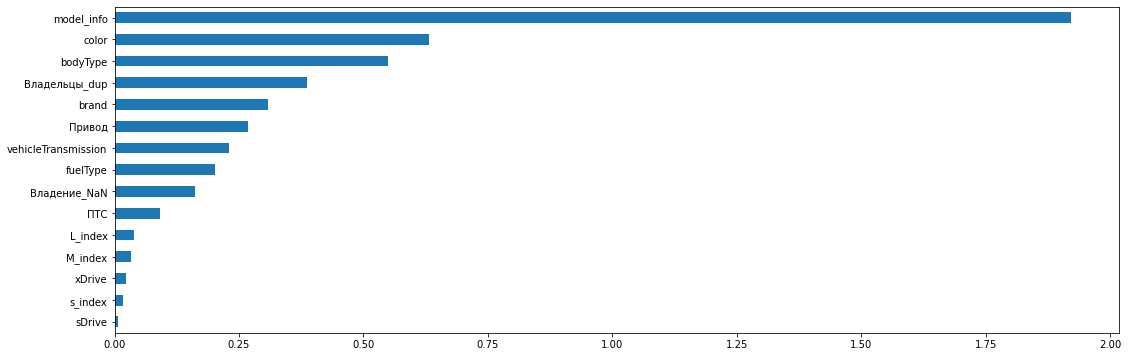

In [46]:
# Do mutual information analysis
mutual_information_analysis(df.loc[df[TRAIN]])

#### Delete useless features
- Delete proportional and highly correlated features, and also features with week correlation with target variable
- Delete features without statistically significant difference

In [47]:
# Define features to delete
cols = []

# Deleting
df.drop(columns=[col for col in cols if col in df.columns], inplace=True)

# Update feature list
categ_bin_cols = [col for col in categ_bin_cols if col in df.columns]
categ_many_cols = [col for col in categ_many_cols if col in df.columns]
categ_multi_cols = [col for col in categ_multi_cols if col in df.columns]
categ_cols = categ_bin_cols + categ_many_cols + categ_multi_cols
quantity_cols = [col for col in quantity_cols if col in df.columns]
quantity_categ_cols = [col for col in quantity_categ_cols if col in df.columns]
ordinal_cols = [col for col in ordinal_cols if col in df.columns]
text_cols = [col for col in text_cols if col in df.columns]

## Dummies generation

In [48]:
def generate_dummies(df, collinear_sens):
    """Dummies generation from categorical features
    
    collinear_sens is ML model collinearity sensitivity. It's either True or False.
    """
    # Generate dummies for categ_multi_cols
    for column in categ_multi_cols:
        df = pd.concat([df, df[column].str.get_dummies()], axis=1)
    df.drop(categ_multi_cols, axis=1, inplace=True)

    # Generate dummies for categ_bin_cols and categ_many_cols
    df = pd.get_dummies(df, columns=categ_bin_cols+categ_many_cols, drop_first=collinear_sens)

#     # scikit-learn realization
#     drop = 'first' if collinear_sens else None
#     zzz = pd.DataFrame(OneHotEncoder(drop=drop, sparse=False).fit_transform(df[categ_bin_cols + categ_many_cols]))
#     df = pd.concat([df, zzz], axis=1).drop(categ_bin_cols + categ_many_cols, axis=1)
    
    return df

In [49]:
# Generate dummies
df = generate_dummies(df, collinear_sens=False)

# Naive model implementation
The model predicts target as the average price value relative to 'model_info' and 'productionDate' features.
## Data preparing

In [50]:
# Prepare data
df, sample_submission = collect_data()
format_features(df)
create_new_features(df)
delete_useless_rows(df)
delete_useless_features(df)
dirty_handling(df)
declare_features_type()
delete_outliers(df, inplace=DROP_TEST_ROWS)
fill_missing_values(df)

   688 outliers are in column 'engineDisplacement'
   492 outliers are in column 'enginePower'
   795 outliers are in column 'enginePower_1'
   319 outliers are in column 'enginePower_dup_1'
   161 outliers are in column 'mileage'
   374 outliers are in column 'mileage_1'
   189 outliers are in column 'modelDate'
   800 outliers are in column 'numberOfDoors'
   142 outliers are in column 'productionDate'
   888 outliers are in column 'sell_id'
    64 outliers are in column 'Владение'
   118 outliers are in column 'Владение_1'
     1 NaN have been replaced in column 'Владельцы'
  5408 NaN have been replaced in column 'Владение'
  5408 NaN have been replaced in column 'Владение_1'
     1 NaN have been replaced in column 'Владельцы_dup'


## Data splitting & Data scaling

In [51]:
# Split data
df_train, df_valid = train_test_split(df.loc[df[TRAIN]], test_size=VALIDATION_SIZE,
                                      shuffle=True, random_state=RANDOM_SEED)

## Model implementation

In [52]:
# Define map
grouped_df = df_train.groupby(['model_info', 'productionDate'])['price'].median()
# Predict using values from the map
prediction = df_valid.apply(lambda x: grouped_df[(x['model_info'], x['productionDate'])]
                            if (x['model_info'], x['productionDate'])
                            in grouped_df.index else np.nan, axis=1)
# Fill values with undefined map indices
prediction = prediction.fillna(prediction.median())

## Model testing

In [53]:
# Evaluate the model
score = 100 * np.mean(np.abs((df_valid['price'] - prediction) / df_valid['price']))
# Show result
print(f"Naive model MAPE: {score:0.2f} %")

Naive model MAPE: 18.70 %


# Classic ML model implementation
## Data preparing

In [54]:
# Prepare data
df, sample_submission = collect_data()
format_features(df)
create_new_features(df)
delete_useless_rows(df)
delete_useless_features(df)
dirty_handling(df)
declare_features_type()
delete_outliers(df, inplace=DROP_TEST_ROWS)
fill_missing_values(df)
columns = list(set(quantity_cols)
               - set([RANDOM, IDENT, 'numberOfDoors', 'engineDisplacement', 'Владельцы']))
df = generate_polynomials(df, columns, collinear_sens=False)
# normalize_distribution(df)
df = generate_dummies(df, collinear_sens=False)

df_temp = df.copy()
df_temp

   688 outliers are in column 'engineDisplacement'
   492 outliers are in column 'enginePower'
   795 outliers are in column 'enginePower_1'
   319 outliers are in column 'enginePower_dup_1'
   161 outliers are in column 'mileage'
   374 outliers are in column 'mileage_1'
   189 outliers are in column 'modelDate'
   800 outliers are in column 'numberOfDoors'
   142 outliers are in column 'productionDate'
   888 outliers are in column 'sell_id'
    64 outliers are in column 'Владение'
   118 outliers are in column 'Владение_1'
     1 NaN have been replaced in column 'Владельцы'
  5408 NaN have been replaced in column 'Владение'
  5408 NaN have been replaced in column 'Владение_1'
     1 NaN have been replaced in column 'Владельцы_dup'


,description,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,sell_id,Владельцы,Владение,TRAIN,price,RANDOM,enginePower_1,mileage_1,productionDate_1,Владение_1,enginePower_dup_1,modelDate^2,modelDate enginePower,...,color_пурпурный,color_серебристый,color_серый,color_синий,color_фиолетовый,color_чёрный,fuelType_бензин,fuelType_гибрид,fuelType_дизель,fuelType_электро,vehicleTransmission_автоматическая,vehicleTransmission_вариатор,vehicleTransmission_механическая,vehicleTransmission_роботизированная,Привод_задний,Привод_передний,Привод_полный,Владельцы_dup_1.0,Владельцы_dup_2.0,Владельцы_dup_3.0
0,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0,220,350000,1984,5,1991,1099427284,3.0,75.000000,False,0.0,89250,0.002081,0.000002,0.025052,0.012431,0.006023,3936256.0,436480.0,...,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1
1,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0,313,15000,2011,2,2013,1096405886,1.0,78.000000,False,0.0,773956,0.002581,0.000013,0.055813,0.011984,0.003861,4044121.0,629443.0,...,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0
2,"Машина тут продаётся не в первый раз, НО! Толь...",2.5,218,166600,2005,2,2008,1100195294,3.0,47.568795,False,0.0,654571,0.002073,0.000004,0.043636,0.030149,0.006097,4020025.0,437090.0,...,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1
3,"Автомобиль в отличном состоянии, весь в родной...",2.0,136,147000,2005,4,2007,1099827282,2.0,47.568795,False,0.0,438878,0.001772,0.000005,0.041811,0.030149,0.012191,4020025.0,272680.0,...,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0
4,Немка! с бесключивым доступом и камерой заднег...,2.0,190,24000,2016,4,2019,1100076198,1.0,47.568795,False,0.0,433015,0.001959,0.000012,0.083913,0.030149,0.007351,4064256.0,383040.0,...,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8347,Комплектация автомобиля:\n\n• розетка 12V\n• ш...,3.0,231,242830,2008,5,2010,1100210010,3.0,47.568795,True,796000.0,295060,0.002130,0.000003,0.047808,0.030149,0.005649,4032064.0,463848.0,...,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1
8348,Продаётся любимый автомобиль! За годы эксплуат...,2.0,150,232777,2005,4,2006,1100036650,3.0,47.568795,True,550000.0,714238,0.001817,0.000003,0.040133,0.030149,0.010414,4020025.0,300750.0,...,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1
8349,Куплена у официального дилера в 2017 г. \n\nТр...,2.0,190,33700,2013,4,2016,1090506038,3.0,26.000000,True,1900000.0,789053,0.001959,0.000010,0.067037,0.031799,0.007351,4052169.0,382470.0,...,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1
8350,Торг на месте. Все работает. Сборка немецкая. ...,2.0,143,200000,2008,4,2008,1095155628,3.0,26.000000,True,530000.0,128584,0.001794,0.000004,0.043636,0.031799,0.011232,4032064.0,287144.0,...,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1


In [55]:
df = df_temp.copy()

## Data splitting & Data scaling

In [56]:
def split_scale_dataframe(data, validation_size, stratify=True, scale=True):
    """Split and scale DataFrame
    
    Splits to X, X_train, X_valid, y, y_train, y_valid.
    Scale by StandardScaler.
    Returns features (X) as pandas DataFrame and target (y) as numpy array."""
    # Split data: Х - features, у - target variable
    X = data.loc[data[TRAIN]].drop([TRAIN, TARGET], axis=1)
    X_test = data.loc[~data[TRAIN]].drop([TRAIN, TARGET], axis=1)
    y = data.loc[data[TRAIN], TARGET].values
    indices = data.loc[data[TRAIN]].index

    # Split data on train and validation parts
    strat = y if stratify else None
    (X_train, X_valid, y_train, y_valid,
     indices_train, indices_valid) = train_test_split(
        X, y, indices, test_size=validation_size, stratify=strat,
        shuffle=True, random_state=RANDOM_SEED
    )

    # Scale data and convert X to DataFrame
    if scale:
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_valid = pd.DataFrame(scaler.fit_transform(X_valid), columns=X_valid.columns)
        X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

    return (X, X_train, X_valid, X_test, y, y_train, y_valid, indices_train, indices_valid)

In [57]:
# Data splitting
(X, X_train, X_valid, X_test, y, y_train, y_valid,
 indices_train, indices_valid) = split_scale_dataframe(
    df.drop(text_cols, axis=1), validation_size=VALIDATION_SIZE, stratify=False
)
print('Shapes:', X.shape, X_train.shape, X_valid.shape, X_test.shape,
      y.shape, y_train.shape, y_valid.shape)

Shapes: (6666, 245) (5332, 245) (1334, 245) (1671, 245) (6666,) (5332,) (1334,)


## CatBoostRegressor model
### Feature selection

In [58]:
def score_vs_sample_value(model, X, y, cv_top, cv_bottom):
    """Calculate train and validation scores versus sample value.
    
    It is in order to detect high bias or high variance.
    It also helps to find optimum sample value to fit model for tuning.
    """
    # Cycle over top CV folds (to average result)
    X = X.values
    score = []
    scaler = StandardScaler()
    for i, (train_index_t, valid_index_t) in enumerate(cv_top.split(X, y)):
        # Top splitting on train and validation parts. Standardize.
        X_train_t, X_valid_t = X[train_index_t, :], X[valid_index_t, :]
        y_train_t, y_valid_t = y[train_index_t], y[valid_index_t]
        X_valid_t = scaler.fit_transform(X_valid_t)

        # Cycle over train size (bottom CV)
        sample_val = []
        score_train = []
        score_valid = []
        train_index_b = np.array([]).astype(int)
        for j, (_, valid_index_b) in enumerate(cv_bottom.split(X_train_t, y_train_t)):
            # Expand train indices
            train_index_b = np.concatenate([train_index_b, valid_index_b])
            
            # Bottom splitting on train and validation parts. Standardize.
            X_train_b = X_train_t[train_index_b, :]
            y_train_b = y_train_t[train_index_b]
            X_train_b = scaler.fit_transform(X_train_b)
            sample_val.append(X_train_b.shape[0])
            
            # Print status
            print(f'Process: top_fold_number = {i+1};', end=' ')
            print(f'bottom_fold_number = {j+1}; train_size = {X_train_b.shape[0]}')
            
            # Learn model
            model.fit(X_train_b, y_train_b)
            
            # Test model
            if PROBLEM == 'Regression':
                if METRIC == 'MAPE':
                    score_train.append(100 * np.mean(np.abs((y_train_b-model.predict(X_train_b)) / y_train_b)))
                    score_valid.append(100 * np.mean(np.abs((y_valid_t-model.predict(X_valid_t)) / y_valid_t)))
                else:
                    raise ValueError
            elif PROBLEM == 'Classification':
                if METRIC == 'ROC AUC':
                    score_train.append(roc_auc_score(y_train_b, model.predict_proba(X_train_b)[:,1]))
                    score_valid.append(roc_auc_score(y_valid_t, model.predict_proba(X_valid_t)[:,1]))
                else:
                    raise ValueError
            else:
                raise ValueError
            
        # Append fold result
        score.append({'sample value': sample_val, METRIC+' train': score_train, METRIC+' valid': score_valid})

    # Average result by number of top CV folds
    length = len(score[0]['sample value'])
    sample_val = [0]*length
    score_train = [0]*length
    score_valid = [0]*length
    for scr in score:
        for i in range(length):
            sample_val[i] += scr['sample value'][i]
            score_train[i] += scr[METRIC+' train'][i]
            score_valid[i] += scr[METRIC+' valid'][i]
    for i in range(length):
        sample_val[i] /= cv_top.get_n_splits()
        score_train[i] /= cv_top.get_n_splits()
        score_valid[i] /= cv_top.get_n_splits()
    
    return pd.DataFrame.from_dict({'sample value': sample_val, METRIC+' train': score_train, METRIC+' valid': score_valid})


def find_usefull_useless_feature(model, X, y, cv, greater_score_is_better, usefull_cols=None):
    """Find the most usefull or useless feature.
    
    Find the most usefull feature to add if 'usefull_cols' is a list.
    Find the most useless feature to drop if 'usefull_cols' is None.
    """
    # Cycle over folds
    # inverse order of train and validation indices
    f_train_score = defaultdict(np.float64)
    f_valid_score = defaultdict(np.float64)
    scaler = StandardScaler()
    for i, (valid_index, train_index) in enumerate(cv.split(X.values, y)):
        # Split on train and validation
        X_train, X_valid = X.iloc[train_index, :], X.iloc[valid_index, :]
        y_train, y_valid = y[train_index], y[valid_index]
        
        # Standardize train and validation parts
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_valid = pd.DataFrame(scaler.fit_transform(X_valid), columns=X_valid.columns)
        
        # Determine features list
        if usefull_cols is not None:
            columns = [col for col in X_train.columns if col not in usefull_cols]
        else:
            columns = X_train.columns # [0:110]
        
        # Cycle over features
        for j, column in enumerate(columns):
            # Define train and validation data
            if usefull_cols is not None:
                cols = usefull_cols + [column]
                X_train_temp = X_train[cols]
                X_valid_temp = X_valid[cols]
            else:
                X_train_temp = X_train.drop(column, axis=1)
                X_valid_temp = X_valid.drop(column, axis=1)

            # Learn model
            model.fit(X_train_temp, y_train)

            # Test model and update dicts
            if PROBLEM == 'Regression':
                if METRIC == 'MAPE':
                    f_train_score[column] += 100 * np.mean(np.abs((y_train-model.predict(X_train_temp)) / y_train))
                    f_valid_score[column] += 100 * np.mean(np.abs((y_valid-model.predict(X_valid_temp)) / y_valid))
                else:
                    raise ValueError
            elif PROBLEM == 'Classification':
                if METRIC == 'ROC AUC':
                    f_train_score[column] += roc_auc_score(y_train, model.predict_proba(X_train_temp)[:,1])
                    f_valid_score[column] += roc_auc_score(y_valid, model.predict_proba(X_valid_temp)[:,1])
                else:
                    raise ValueError
            else:
                raise ValueError

            # Print status for every feature
            print(f'Completed: fold_number = {i+1}; feature_number = {j+1}; mean_validation_score[{column}] = {f_valid_score[column] / (i+1)}')
        
        # Print status for every fold
        if greater_score_is_better:
            feature = max(f_valid_score, key=f_valid_score.get)
        else:
            feature = min(f_valid_score, key=f_valid_score.get)
        print(feature, f_valid_score[feature] / (i+1))

    # Average result
    for column in f_train_score.keys():
        f_train_score[column] /= cv.get_n_splits()
        f_valid_score[column] /= cv.get_n_splits()
    
    # Form result DataFrame
    result = pd.DataFrame.from_dict([f_train_score, f_valid_score]).transpose().reset_index()
    result.columns = ['feature', METRIC+' train', METRIC+' valid']
    
    return result.sort_values(METRIC+' valid', ascending=not greater_score_is_better, ignore_index=True)


def find_several_usefull_useless_features(
    model, X, y, features_num, cv, greater_score_is_better, usefull_cols=None
):
    """Find several usefull of useless features at a time.
    
    Find the most usefull features to add if 'usefull_cols' is a list.
    Find the most useless features to drop if 'usefull_cols' is None.
    """
    # Find exact features_num
    if usefull_cols is not None:
        features_num = min(features_num, X.shape[1] - len(usefull_cols))
    else:
        features_num = min(features_num, X.shape[1])

    # Find features
    useless_cols = []
    features_score = pd.DataFrame(columns=['feature', METRIC+' train', METRIC+' valid'])
    for i in range(features_num):
        if usefull_cols is not None:
            # Find usefull feature and append it
            df_score = find_usefull_useless_feature(
                model, X, y, cv, greater_score_is_better,
                usefull_cols=usefull_cols,
            )
            usefull_cols.append(df_score.iloc[0, 0])
        else:
            # Find useless feature and drop it
            df_score = find_usefull_useless_feature(
                model, X.drop(useless_cols, axis=1), y, cv,
                greater_score_is_better,
            )
            useless_cols.append(df_score.iloc[0, 0])

        # Print and save an intermediate result
        features_score = features_score.append(df_score.iloc[0], ignore_index=True)
        features_score.to_csv('score_vs_feature_number_new.csv', index=False)
        print('Feature number =', i+1)
        print(features_score)
        
    return features_score

In [59]:
# Model before tuning
model_before_t = CatBoostRegressor(iterations=5000,
                                   #depth=10,
                                   #learning_rate=0.5,
                                   random_seed=RANDOM_SEED,
                                   eval_metric='MAPE',
                                   custom_metric=['RMSE', 'MAE'],
                                   od_wait=500,
                                   #task_type='GPU',
                                  )

   sample value  MAPE train  MAPE valid
0         250.0    2.098279   24.262594
CPU times: user 114 ms, sys: 6.09 ms, total: 120 ms
Wall time: 155 ms


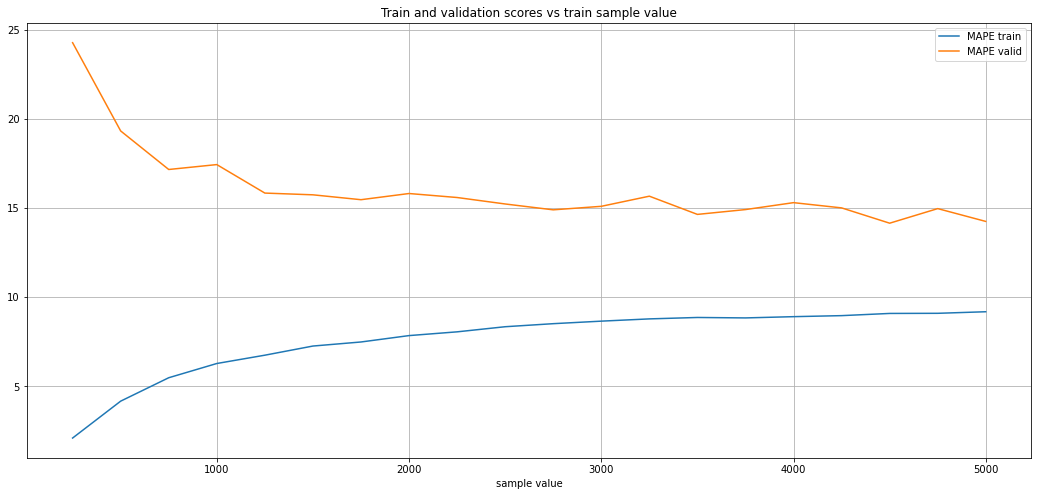

In [60]:
%%time
# Usefull columns before tuning
# usefull_cols_before_t = X.columns
usefull_cols_before_t = X.drop([RANDOM, IDENT], axis=1).columns
# usefull_cols_before_t = [
# ]

# Define cross-validation
CV_TOP = 4 # CV to average result
CV_BOTTOM = 20 # CV to split sample value
if PROBLEM == 'Regression':
    cv_top = KFold(n_splits=CV_TOP, shuffle=True, random_state=RANDOM_SEED)
    cv_bottom = KFold(n_splits=CV_BOTTOM, shuffle=True, random_state=RANDOM_SEED)
elif PROBLEM == 'Classification':
    cv_top = StratifiedKFold(n_splits=CV_TOP, shuffle=True, random_state=RANDOM_SEED)
    cv_bottom = StratifiedKFold(n_splits=CV_BOTTOM, shuffle=True, random_state=RANDOM_SEED)

# Compute train and validation scores versus sample value to define
# whether the model has high bias or high variance
# and find optimum train-validation sample proportion to tune features
# score = score_vs_sample_value(
#     model=model_before_t,
#     X=X[usefull_cols_before_t],
#     y=y,
#     cv_top=cv_top,
#     cv_bottom=cv_bottom,
# )

# Update sample value score dataframe
score = pd.read_csv(PATH_KERNEL+'score_vs_sample_value.csv')
score['MAPE train'] = score['MAPE train'] * 100
score['MAPE valid'] = score['MAPE valid'] * 100
score.to_csv('score_vs_sample_value.csv', index=False)

# Plot train and validation scores versus sample value
score.plot(x='sample value', figsize=(18, 8), grid=True, title='Train and validation scores vs train sample value')
print(score.nlargest(1, METRIC+' valid'))

The sample value of 1250 for train set is a good choice to find usefull features

In [61]:
%%time
# Already found usefull features
usefull_cols = usefull_cols_before_t
# usefull_cols = [
# ]

# Define parameters
features_num = 8 # Number of features to find next
sample_value = 1250 # Sample value to use

# Compute next usefull features
n_splits = round(df.shape[0] / sample_value)
n_splits = n_splits if n_splits >= 2 else 2
if PROBLEM == 'Regression':
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
elif PROBLEM == 'Classification':
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
# find_several_usefull_useless_features(
#     model=model_before_t,
#     X=X,
#     y=y,
#     features_num=features_num,
#     cv=cv,
#     greater_score_is_better=False,
#     usefull_cols=usefull_cols,
# )

# Update features score dataframe
# First time
# features_score = pd.read_csv(PATH_WORKING+'score_vs_feature_number_new.csv')
# features_score.to_csv('score_vs_feature_number.csv', index=False)
# Next times
# features_score = pd.read_csv(PATH_KERNEL+'score_vs_feature_number.csv')
# features_score_new = pd.read_csv(PATH_WORKING+'score_vs_feature_number_new.csv')
# features_score = features_score.append(features_score_new, ignore_index=True)
# features_score.to_csv('score_vs_feature_number.csv', index=False)
# Done
# features_score = pd.read_csv(PATH_KERNEL+'score_vs_feature_number.csv')
# features_score.to_csv('score_vs_feature_number.csv', index=False)

# Plot train and validation scores versus number of features
# features_score['features number'] = features_score.index + 1
# features_score.plot(x='features number', figsize=(18, 8), grid=True,
#     title='Train and validation scores vs number of features');#, ylim=(0.735, 0.738));
# print(features_score.nlargest(1, METRIC+' valid'))
# features_score['feature'].values

CPU times: user 53 µs, sys: 6 µs, total: 59 µs
Wall time: 62 µs


## Hyperparameters tuning

**View scorers or create your own**

In [62]:
# Show available metrics to optimize hyperparameters
# sorted(SCORERS.keys())

# Create MAPE scorer
def mape_score_func(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true-y_pred) / y_true))
mape_scorer = make_scorer(mape_score_func, greater_is_better=False)

**Tuning**

In [63]:
%%time
# Define model
model = model_before_t
# model = CatBoostRegressor(iterations=5000,
#                         #depth=10,
#                         #learning_rate=0.5,
#                         random_seed=RANDOM_SEED,
#                         eval_metric='MAPE',
#                         custom_metric=['RMSE', 'MAE'],
#                         od_wait=500,
#                         #task_type='GPU',
#                        )

# Define parameters grid
parameters = {
#     'criterion': ['mse', 'mae'],
#     'max_depth': np.geomspace(start=2, stop=20, num=5).astype(int),
#     'max_features': ['auto', 'sqrt', 'log2', 1/3],
             }

# Define cross validation
n_splits = 4
if PROBLEM == 'Regression':
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
elif PROBLEM == 'Classification':
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

# Define scorer
scorer= mape_scorer

# Define and fit grid search
# grs = GridSearchCV(estimator=model, param_grid=parameters, scoring=scorer,
#                      cv=cv, n_jobs=-1, verbose=2)
# grs.fit(X[usefull_cols], y)

# # Print result
# print('cv_results_:', grs.cv_results_)
# print()
# print('best_estimator_:', grs.best_estimator_)
# print()
# print('best_score_:', grs.best_score_)
# print()
# print('best_params_:', grs.best_params_)

CPU times: user 35 µs, sys: 4 µs, total: 39 µs
Wall time: 42 µs


In [64]:
np.geomspace(start=2, stop=20, num=5).astype(int)

array([ 2,  3,  6, 11, 20])

## Model testing
**Score evaluation**

In [65]:
%%time
# Define cross validation
n_splits = 3
n_repeats = 1
if PROBLEM == 'Regression':
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=RANDOM_SEED)
elif PROBLEM == 'Classification':
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=RANDOM_SEED)

# Evaluate model
score = cross_val_score(
    model, X[usefull_cols], y, scoring=mape_scorer, cv=cv, n_jobs=-1, verbose=1
)
print('Shapes:', X[usefull_cols].shape, y.shape)
print('Mean', METRIC, 'score =', np.mean(score))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Shapes: (6666, 243) (6666,)
Mean MAPE score = -13.51185259710101
CPU times: user 83.5 ms, sys: 64.6 ms, total: 148 ms
Wall time: 3min 49s


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.8min finished


**Learn model on 100% of train data**

In [66]:
# Learn model on 100% of train data
model.fit(X[usefull_cols], y, logging_level='Silent')

# Show train and validation score
print(f'Train {METRIC}:', 100 * np.mean(np.abs((y_train-model.predict(X_train)) / y_train)))
print(f'Valid {METRIC}:', 100 * np.mean(np.abs((y_valid-model.predict(X_valid)) / y_valid)))

Train MAPE: 10.267925237698696
Valid MAPE: 10.55865172256065


**Model characteristics**

In [67]:
# # View model characteristics
# print('base_estimator_:', model.base_estimator_)
# print()
# print('estimators_:', model.estimators_)
# print()
# print('feature_importances_:', model.feature_importances_)
# print()
# print('n_features_:', model.n_features_)
# print()
# print('n_outputs_:', model.n_outputs_)
# print()
# print('oob_score_:', model.oob_score_)
# print()
# print('oob_prediction_:', model.oob_prediction_)

# NN model implementation

In [68]:
# G L O B A L   C O N S T A N T S
CLASS_NUM            = 1     # Number of classes (1 for binary and for regression problem)
TABULAR_INPUT_DIM    = len(usefull_cols) # NN input dimention
LOSS_FUNC            = 'MAPE' # Loss function
METRIC               = 'MAPE' # Metric

# H Y P E R P A R A M E T E R S
EPOCHS               = 500   # Epochs to learn
BATCH_SIZE           = 512   # Batch size to learn
LR_FACTOR            = 0.98  # Factor for decreasing learning rate every training epoch

## Configure checkpoint list

In [69]:
# Configure checkpoint list
checkpoint = ModelCheckpoint(filepath='best_model_tabular.hdf5',
                             monitor='val_' + METRIC,
                             verbose=1,
                             save_best_only=True,
                             mode='max',)
earlystop = EarlyStopping(monitor='val_' + METRIC,
                          patience=100,
                          restore_best_weights=True,)
lr_scheduler = LearningRateScheduler(lambda epoch, lr: lr * LR_FACTOR)
callbacks_list = [checkpoint, earlystop, lr_scheduler]

## Model assembling

In [70]:
# Clear session
clear_session()

model = Sequential()
model.add(Dense(512, input_dim=TABULAR_INPUT_DIM, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(CLASS_NUM, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               124928    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 256,513
Trainable params: 256,513
Non-trainable params: 0
_________________________________________________________________


## Model learning
### Evaluating metric before learning

In [71]:
# Compile the model
model.compile(loss=LOSS_FUNC, metrics=[METRIC])

# Compute score
scores = model.evaluate(X_valid[usefull_cols].values, y_valid)
print(f'Validation loss: %.2f %%' % scores[0])
print(f'Validation {METRIC}: %.2f %%' % scores[1])

42/42 [==============================] - 1s 1ms/step - loss: 100.0000 - MAPE: 100.0000
Validation loss: 100.00 %
Validation MAPE: 100.00 %


### Range test for learning rate

In [72]:
def lr_range_test(model, X, y, steps_num=5, init_lr=1e-4, max_lr=10):
    """Range test for learning rate.
    
    steps_num - number of steps from init_lr to max_lr
    init_lr - initial LR
    max_lr - maximum LR
    """

    # Factor for learning rate increasing
    lr_factor = (max_lr/init_lr)**(1/steps_num)

    # Define learning rate scheduler
    callback = LearningRateScheduler(lambda epoch, lr: lr * lr_factor)

    # Compile the model
    model.compile(optimizer=Adam(lr=init_lr),
                  loss=LOSS_FUNC,
                  metrics=[METRIC],)

    # Train the model
    history = model.fit(X, y, epochs=steps_num + 1, callbacks=[callback])
    

# lr_range_test(model, X_valid[usefull_cols].values, y_valid, steps_num=6, init_lr=1e-2, max_lr=1e0)

$$ lr_{i} = init\_lr\cdot\Bigg(\frac{max\_lr}{init\_lr}\Bigg)^{\frac{i}{steps\_num}} $$

$$ i = epoch\_num-1 $$

The minimum loss is detected at the learning rate about $1\cdot10^{-1}$. We should choose maximum learning rate one order lower than the learning rate where loss is minimum. So maximum learning rate equals to $1\cdot10^{-2}$.

### Learning

In [73]:
def learn_model(learning_rate=0.001, epochs=EPOCHS):
    """Compile and train model."""
    # Compile
    model.compile(optimizer=Adam(lr=learning_rate),
                  loss=LOSS_FUNC,
                  metrics=[METRIC])
    
    # Train the model
    return model.fit(
        X_train[usefull_cols].values,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=epochs,
        callbacks=callbacks_list,
        validation_data=(X_valid[usefull_cols].values, y_valid),
        shuffle=True,
        verbose=1,
    )

def plot_history(history):
    """Plot learning process graphs."""
    metric = history.history[METRIC]
    val_metric = history.history['val_' + METRIC]
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(metric) + 1)

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, metric, 'b', label='Training')
    plt.plot(epochs, val_metric, 'r', label='Validation')
    plt.title(METRIC)
    plt.legend()

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, loss, 'b', label='Training')
    plt.plot(epochs, val_loss, 'r', label='Validation')
    plt.title('Loss')
    plt.legend()

In [74]:
history = learn_model(1e-2)

Epoch 1/500
11/11 [==============================] - 1s 55ms/step - loss: 99.9943 - MAPE: 99.9943 - val_loss: 99.9035 - val_MAPE: 99.9035

Epoch 00001: val_MAPE improved from -inf to 99.90353, saving model to best_model_tabular.hdf5
Epoch 2/500
11/11 [==============================] - 0s 8ms/step - loss: 99.7426 - MAPE: 99.7426 - val_loss: 98.7290 - val_MAPE: 98.7290

Epoch 00002: val_MAPE did not improve from 99.90353
Epoch 3/500
11/11 [==============================] - 0s 8ms/step - loss: 97.8842 - MAPE: 97.8842 - val_loss: 93.8317 - val_MAPE: 93.8317

Epoch 00003: val_MAPE did not improve from 99.90353
Epoch 4/500
11/11 [==============================] - 0s 8ms/step - loss: 91.4620 - MAPE: 91.4620 - val_loss: 83.5927 - val_MAPE: 83.5927

Epoch 00004: val_MAPE did not improve from 99.90353
Epoch 5/500
11/11 [==============================] - 0s 8ms/step - loss: 82.9292 - MAPE: 82.9292 - val_loss: 81.6243 - val_MAPE: 81.6243

Epoch 00005: val_MAPE did not improve from 99.90353
Epoch 6

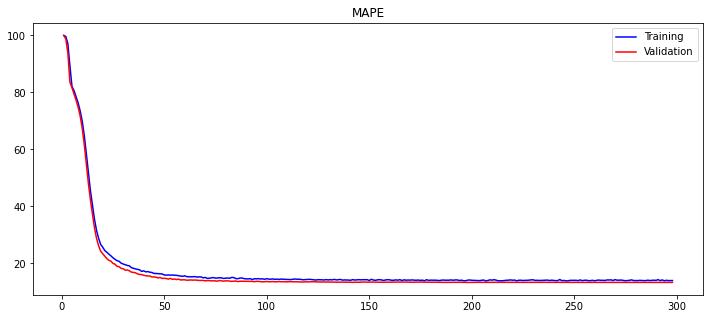

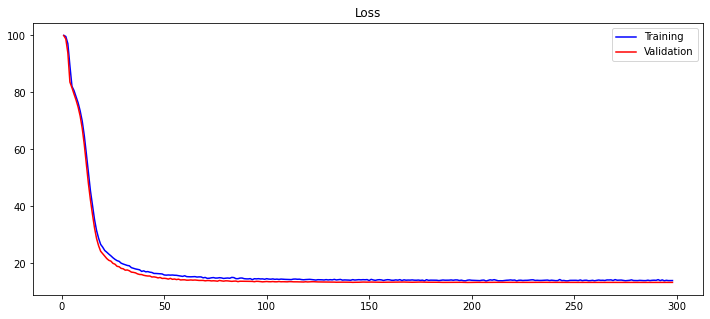

In [75]:
plot_history(history)

## Model evaluation

In [76]:
# Compile the model
model.compile(loss=LOSS_FUNC, metrics=[METRIC])

# Compute score
scores = model.evaluate(X_valid[usefull_cols].values, y_valid)
print(f'Validation loss: %.2f %%' % scores[0])
print(f'Validation {METRIC}: %.2f %%' % scores[1])

42/42 [==============================] - 0s 2ms/step - loss: 12.7411 - MAPE: 12.7411
Validation loss: 13.32 %
Validation MAPE: 13.32 %


# NLP + tabular model implementation

In [77]:
# G L O B A L   C O N S T A N T S
CLASS_NUM            = 1      # Number of classes (1 for binary and for regression problem)
TABULAR_INPUT_DIM    = len(usefull_cols) # NN input dimention
LOSS_FUNC            = 'MAPE' # Loss function
METRIC               = 'MAPE' # Metric

# H Y P E R P A R A M E T E R S
EPOCHS               = 100   # Epochs to learn
BATCH_SIZE           = 512   # Batch size to learn
LR_FACTOR            = 0.98   # Factor for decreasing learning rate every training epoch
MAX_WORDS            = 100000 # Maximum number of words to be used (most frequent)
MAX_SEQUENCE_LENGTH  = 256    # Maximum number of words in each example

In [78]:
text_join = df[text_cols].iloc[:, 0]
text_test = df.loc[~df[TRAIN], text_cols].iloc[:, 0]
text_train = df.loc[indices_train, text_cols].iloc[:, 0]
text_valid = df.loc[indices_valid, text_cols].iloc[:, 0]
text_join

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8347    Комплектация автомобиля:\n\n• розетка 12V\n• ш...
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
Name: description, Length: 8337, dtype: object

In [79]:
print('Shapes:', text_join.shape, text_test.shape, text_train.shape, text_valid.shape)

Shapes: (8337,) (1671,) (5332,) (1334,)


## Text tokenization & vectorization

In [80]:
%%time
# Tokenization
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(text_join)
print('Number of words:', len(tokenizer.word_index))

Number of words: 39496
CPU times: user 1.35 s, sys: 2.21 ms, total: 1.36 s
Wall time: 1.36 s


In [81]:
tokenizer.word_index

{'•': 1,
 'в': 2,
 'и': 3,
 'с': 4,
 'на': 5,
 'не': 6,
 'по': 7,
 'система': 8,
 'автомобиль': 9,
 'все': 10,
 'для': 11,
 'автомобиля': 12,
 'от': 13,
 'до': 14,
 'при': 15,
 'пробегом': 16,
 'у': 17,
 '2': 18,
 'состоянии': 19,
 'без': 20,
 'авто': 21,
 'салон': 22,
 'пакет': 23,
 'за': 24,
 'машина': 25,
 'автомобилей': 26,
 'сидений': 27,
 'птс': 28,
 'безопасности': 29,
 'то': 30,
 'bmw': 31,
 'из': 32,
 'более': 33,
 '000': 34,
 'автомобили': 35,
 'водителя': 36,
 'комплектация': 37,
 'есть': 38,
 '1': 39,
 'года': 40,
 'комплект': 41,
 'сиденья': 42,
 'только': 43,
 'дилера': 44,
 'салона': 45,
 'пробег': 46,
 'контроль': 47,
 'фары': 48,
 '6': 49,
 'диски': 50,
 'кредит': 51,
 'лет': 52,
 'передние': 53,
 '3': 54,
 'руля': 55,
 'датчик': 56,
 'пассажира': 57,
 'км': 58,
 'оригинал': 59,
 'подушки': 60,
 'а': 61,
 'мы': 62,
 'подогрев': 63,
 '9': 64,
 'заднего': 65,
 'состояние': 66,
 'вас': 67,
 '5': 68,
 'обслуживание': 69,
 'зеркал': 70,
 'торг': 71,
 '–': 72,
 'дтп': 73,
 '

In [82]:
%%time
# Vectorization
text_train_sequences = sequence.pad_sequences(tokenizer.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_valid_sequences = sequence.pad_sequences(tokenizer.texts_to_sequences(text_valid), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenizer.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
print('Shapes:', text_train_sequences.shape, text_valid_sequences.shape, text_test_sequences.shape)

Shapes: (5332, 256) (1334, 256) (1671, 256)
CPU times: user 1.36 s, sys: 4.35 ms, total: 1.36 s
Wall time: 1.36 s


## Configure checkpoint list

In [83]:
# Configure checkpoint list
checkpoint = ModelCheckpoint(filepath='best_model_NLP.hdf5',
                             monitor='val_' + METRIC,
                             verbose=1,
                             save_best_only=True,
                             mode='max',)
earlystop = EarlyStopping(monitor='val_' + METRIC,
                          patience=20,
                          restore_best_weights=True,)
lr_scheduler = LearningRateScheduler(lambda epoch, lr: lr * LR_FACTOR)
callbacks_list = [checkpoint, earlystop, lr_scheduler]

## Model assembling
NLP part

In [84]:
clear_session()

# RNN LSTM
model_nlp = Sequential()
model_nlp.add(Input(shape=MAX_SEQUENCE_LENGTH, name='seq_description'))
model_nlp.add(Embedding(len(tokenizer.word_index)+1, MAX_SEQUENCE_LENGTH))
model_nlp.add(LSTM(256, return_sequences=True))
model_nlp.add(Dropout(0.5))
model_nlp.add(LSTM(128))
model_nlp.add(Dropout(0.25))
model_nlp.add(Dense(64, activation='relu'))
model_nlp.add(Dropout(0.25))

Tabular part

In [85]:
# MLP
model_tab = Sequential()
model_tab.add(Dense(512, input_dim=TABULAR_INPUT_DIM, activation='relu'))
model_tab.add(Dropout(0.5))
model_tab.add(Dense(256, activation='relu'))
model_tab.add(Dropout(0.5))

Whole NN (multiple inputs)

In [86]:
# Combined input
combined_input = concatenate([model_nlp.output, model_tab.output])
# Regression head
head = Dense(64, activation='relu')(combined_input)
head = Dense(CLASS_NUM, activation='linear')(head)
# Join parts
model = Model(inputs=[model_nlp.input, model_tab.input], outputs=head)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     10111232    seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256)     0           lstm[0][0]                       
______________________________________________________________________________________________

## Model learning
### Evaluating metric before learning

In [87]:
# Compile the model
model.compile(loss=LOSS_FUNC, metrics=[METRIC])

# Compute score
scores = model.evaluate([text_valid_sequences, X_valid[usefull_cols].values], y_valid)
print(f'Validation loss: %.2f %%' % scores[0])
print(f'Validation {METRIC}: %.2f %%' % scores[1])

42/42 [==============================] - 4s 15ms/step - loss: 100.0000 - MAPE: 100.0000
Validation loss: 100.00 %
Validation MAPE: 100.00 %


### Range test for learning rate

In [88]:
# lr_range_test(model, [text_valid_sequences, X_valid[usefull_cols].values],
#               y_valid, steps_num=6, init_lr=1e-2, max_lr=1e0)

### Learning

In [89]:
def learn_model(learning_rate=0.001, epochs=EPOCHS):
    """Compile and train model."""
    # Compile
    model.compile(optimizer=Adam(lr=learning_rate),
                  loss=LOSS_FUNC,
                  metrics=[METRIC])
    
    # Train the model
    return model.fit(
        [text_train_sequences, X_train[usefull_cols].values],
        y_train,
        batch_size=BATCH_SIZE,
        epochs=epochs,
        callbacks=callbacks_list,
        validation_data=([text_valid_sequences, X_valid[usefull_cols].values], y_valid),
        shuffle=True,
        verbose=1,
    )

def plot_history(history):
    """Plot learning process graphs."""
    metric = history.history[METRIC]
    val_metric = history.history['val_' + METRIC]
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(metric) + 1)

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, metric, 'b', label='Training')
    plt.plot(epochs, val_metric, 'r', label='Validation')
    plt.title(METRIC)
    plt.legend()

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, loss, 'b', label='Training')
    plt.plot(epochs, val_loss, 'r', label='Validation')
    plt.title('Loss')
    plt.legend()

In [90]:
history = learn_model(1e-2)

Epoch 1/100
11/11 [==============================] - 8s 465ms/step - loss: 99.9839 - MAPE: 99.9839 - val_loss: 99.5630 - val_MAPE: 99.5630

Epoch 00001: val_MAPE improved from -inf to 99.56296, saving model to best_model_NLP.hdf5
Epoch 2/100
11/11 [==============================] - 4s 359ms/step - loss: 98.3027 - MAPE: 98.3027 - val_loss: 88.1332 - val_MAPE: 88.1332

Epoch 00002: val_MAPE did not improve from 99.56296
Epoch 3/100
11/11 [==============================] - 4s 374ms/step - loss: 84.6791 - MAPE: 84.6791 - val_loss: 81.3009 - val_MAPE: 81.3009

Epoch 00003: val_MAPE did not improve from 99.56296
Epoch 4/100
11/11 [==============================] - 4s 378ms/step - loss: 79.1579 - MAPE: 79.1579 - val_loss: 74.4601 - val_MAPE: 74.4601

Epoch 00004: val_MAPE did not improve from 99.56296
Epoch 5/100
11/11 [==============================] - 4s 363ms/step - loss: 72.4342 - MAPE: 72.4342 - val_loss: 63.6382 - val_MAPE: 63.6382

Epoch 00005: val_MAPE did not improve from 99.56296
Ep

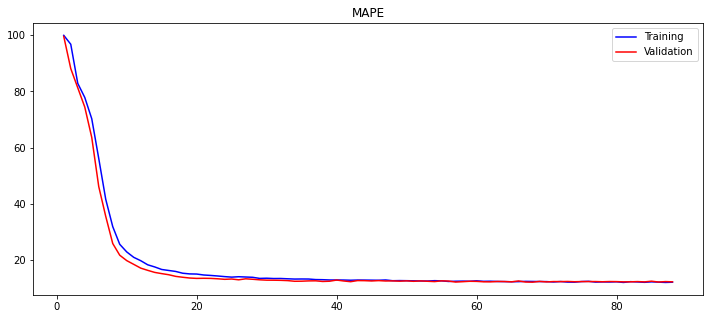

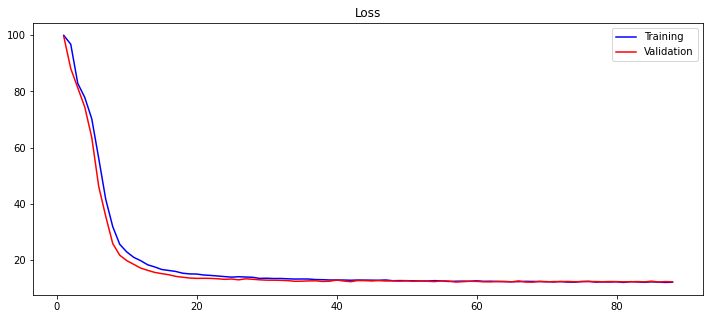

In [91]:
plot_history(history)

## Model evaluation

In [92]:
# Compile the model
model.compile(loss=LOSS_FUNC, metrics=[METRIC])

# Compute score
scores = model.evaluate([text_valid_sequences, X_valid[usefull_cols].values], y_valid)
print(f'Validation loss: %.2f %%' % scores[0])
print(f'Validation {METRIC}: %.2f %%' % scores[1])

42/42 [==============================] - 2s 16ms/step - loss: 11.6019 - MAPE: 11.6019
Validation loss: 12.16 %
Validation MAPE: 12.16 %


# CV + NLP + tabular model implementation

In [93]:
# G L O B A L   C O N S T A N T S
CLASS_NUM            = 1      # Number of classes (1 for binary and for regression problem)
TABULAR_INPUT_DIM    = len(usefull_cols) # NN input dimention
LOSS_FUNC            = 'MAPE' # Loss function
METRIC               = 'MAPE' # Metric

# H Y P E R P A R A M E T E R S
EPOCHS               = 30   # Epochs to learn
BATCH_SIZE           = 512   # Batch size to learn
LR_FACTOR            = 0.98   # Factor for decreasing learning rate every training epoch
IMAGE_INPUT_SHAPE    = (240, 320, 3)
MAX_WORDS            = 100000 # Maximum number of words to be used (most frequent)
MAX_SEQUENCE_LENGTH  = 256    # Maximum number of words in each example

## Text data processing
### Data splitting

In [94]:
text_join = df[text_cols].iloc[:, 0]
text_test = df.loc[~df[TRAIN], text_cols].iloc[:, 0]
text_train = df.loc[indices_train, text_cols].iloc[:, 0]
text_valid = df.loc[indices_valid, text_cols].iloc[:, 0]
text_join

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8347    Комплектация автомобиля:\n\n• розетка 12V\n• ш...
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
Name: description, Length: 8337, dtype: object

In [95]:
print('Shapes:', text_join.shape, text_test.shape, text_train.shape, text_valid.shape)

Shapes: (8337,) (1671,) (5332,) (1334,)


### Text tokenization

In [96]:
%%time
# Tokenization
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(text_join)
print('Number of words:', len(tokenizer.word_index))

Number of words: 39496
CPU times: user 1.4 s, sys: 6.03 ms, total: 1.41 s
Wall time: 1.41 s


## Image data processing
### View image formats

In [97]:
# Initialize counters
img_format_cnt = Counter()
img_mode_cnt = Counter()
img_size_cnt = Counter()

# Compute frequency count for image formats
for i in tqdm(df.index):
    img_path = PATH_IMAGE + str(df.loc[i, 'sell_id']) + '.jpg'
    img = PIL.Image.open(img_path)
    img_format_cnt[img.format] += 1
    img_mode_cnt[img.mode] += 1
    img_size_cnt[img.size] += 1
    
# Show result
print('Formats:', img_format_cnt)
print()
print('Modes:', img_mode_cnt)
print()
print('Sizes:', img_size_cnt.most_common(10))

100%|██████████| 8337/8337 [00:48<00:00, 170.77it/s]

Formats: Counter({'JPEG': 8337})

Modes: Counter({'RGB': 8336, 'L': 1})

Sizes: [((320, 240), 8334), ((160, 120), 1), ((320, 224), 1), ((240, 240), 1)]


### View random image sample

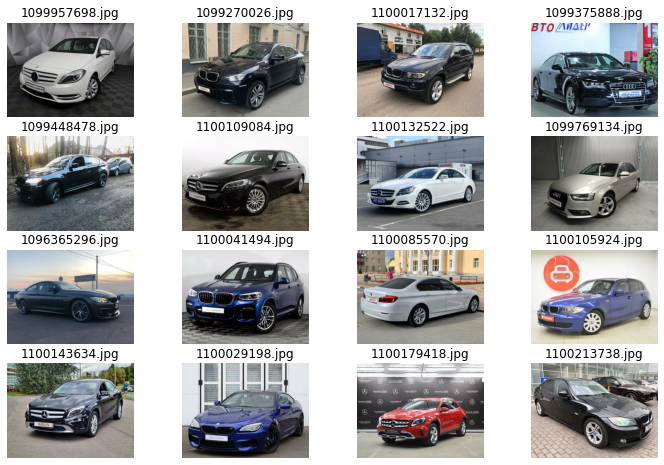

In [98]:
# Number of images in the sample (squared number)
sample_value = 4**2
# Number of subplots per row
subplot_len = math.ceil(math.sqrt(sample_value))
# Sample DataFrame 
df_sample = df.sample(n=sample_value)
# Init figure
plt.figure(figsize=(12, 8))
# Cycle over images to plot
for i, row_index in enumerate(df_sample.index):
    img_path = PATH_IMAGE + str(df_sample.loc[row_index, 'sell_id']) + '.jpg'
    img = PIL.Image.open(img_path)
    plt.subplot(subplot_len, subplot_len, i + 1)
    plt.imshow(img)
    plt.title(str(df_sample.loc[row_index, 'sell_id']) + '.jpg')
    plt.axis('off')
plt.show()

JPEG
RGB
(320, 240)
{'jfif': 257, 'jfif_version': (1, 1), 'jfif_unit': 0, 'jfif_density': (1, 1)}


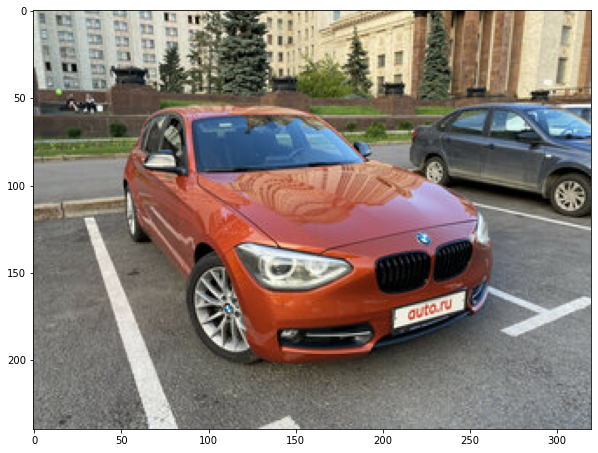

In [99]:
# Show one image example and it's format
img = PIL.Image.open(PATH_IMAGE + '1099416678.jpg')
plt.figure(figsize=(10, 10))
plt.imshow(img)
print(img.format)
print(img.mode)
print(img.size)
print(img.info)

### Data splitting

In [100]:
def get_image_array(indices):
    size = (IMAGE_INPUT_SHAPE[1], IMAGE_INPUT_SHAPE[0])
    img_array = []
    for index in tqdm(indices):
        img = cv2.imread(PATH_IMAGE + str(index) + '.jpg')
#         img = PIL.Image.open(PATH_IMAGE + str(index) + '.jpg')
        assert(img is not None)
        img = cv2.resize(img, size)
#         img = img.resize(size, PIL.Image.ANTIALIAS)
#         if np.array(img).shape != (240, 320, 3):
#             print(np.array(img).shape)
#             assert False
        img_array.append(img)
    img_array = np.array(img_array)
    print('Images shape', img_array.shape, 'dtype', img_array.dtype)
    return(img_array)

img_train = get_image_array(df.loc[indices_train, 'sell_id'])
img_valid = get_image_array(df.loc[indices_valid, 'sell_id'])
img_test = get_image_array(df.loc[~df[TRAIN], 'sell_id'])

  3%|▎         | 44/1334 [00:00<00:02, 436.66it/s]

Images shape (5332, 240, 320, 3) dtype uint8


  3%|▎         | 44/1671 [00:00<00:03, 432.80it/s]

Images shape (1334, 240, 320, 3) dtype uint8


100%|██████████| 1671/1671 [00:04<00:00, 384.80it/s]


Images shape (1671, 240, 320, 3) dtype uint8


### Augmentation

In [101]:
# Configure augmentation
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.OneOf([
        A.ShiftScaleRotate(shift_limit=0.0, scale_limit=0.20,
                           rotate_limit=25, p=0.5),
        A.OpticalDistortion(distort_limit=0.3, shift_limit=0.3,
                            interpolation=1, border_mode=4,
                            value=None, mask_value=None, p=0.5),
    ], p=1),
    A.OneOf([
        A.JpegCompression(quality_lower=60, quality_upper=100, p=0.5),
        A.Blur(blur_limit=5, p=0.5),
    ], p=1),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2,
                  hue=0.4, p=1),
])

View augmented images

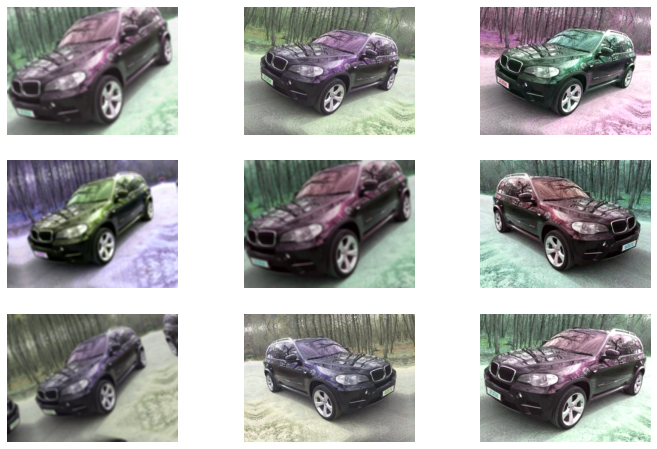

In [102]:
# Number of images in the sample (squared number)
sample_value = 3**2
# Number of subplots per axis
subplot_len = math.ceil(math.sqrt(sample_value))
# Init figure
plt.figure(figsize=(12,8))
# Cycle over images to plot
for i in range(sample_value):
    img = augmentation(image=img_train[4])['image']
    plt.subplot(subplot_len, subplot_len, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

## Configure batches

In [103]:
def process_image(image):
    return augmentation(image=image.numpy())['image']

def vectorize_text(text):
    decoded_text = [text.numpy().decode('utf-8')]
    return sequence.pad_sequences(tokenizer.texts_to_sequences(decoded_text),
                                  maxlen=MAX_SEQUENCE_LENGTH)[0]

def tf_process_train_dataset_element(image, text, table, target):
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(image.shape)
    [text,] = tf.py_function(vectorize_text, [text], [tf.int32])
    return (image, text, table), target

def tf_process_valid_dataset_element(image, text, table, target):
    [text,] = tf.py_function(vectorize_text, [text], [tf.int32])
    return (image, text, table), target


img_train_dataset = tf.data.Dataset.from_tensor_slices((
    img_train, text_train, X_train[usefull_cols], y_train
    )).map(tf_process_train_dataset_element)

img_valid_dataset = tf.data.Dataset.from_tensor_slices((
    img_valid, text_valid, X_valid[usefull_cols], y_valid
    )).map(tf_process_valid_dataset_element)

y_test = np.zeros(X_test.shape[0])
img_test_dataset = tf.data.Dataset.from_tensor_slices((
    img_test, text_test, X_test[usefull_cols], y_test
    )).map(tf_process_valid_dataset_element)

# Checking (no exeption will be asserted)
img_train_dataset.__iter__().__next__();
img_valid_dataset.__iter__().__next__();
img_test_dataset.__iter__().__next__();

## Configure checkpoint list

In [104]:
# Configure checkpoint list
checkpoint = ModelCheckpoint(filepath='best_model_CV.hdf5',
                             monitor='val_' + METRIC,
                             verbose=1,
                             save_best_only=True,
                             mode='max',)
earlystop = EarlyStopping(monitor='val_' + METRIC,
                          patience=5,
                          restore_best_weights=True,)
lr_scheduler = LearningRateScheduler(lambda epoch, lr: lr * LR_FACTOR)
callbacks_list = [checkpoint, earlystop, lr_scheduler]

## Model assembling
CV part

In [105]:
clear_session()

# Pre-trained EfficientNet
model_cv = EfficientNetB3(include_top=False, input_shape=IMAGE_INPUT_SHAPE)
model_cv_output = GlobalAveragePooling2D()(model_cv.output)

43941888/43941136 [==============================] - 1s 0us/step


NLP part

In [106]:
# RNN LSTM
model_nlp = Sequential()
model_nlp.add(Input(shape=MAX_SEQUENCE_LENGTH, name='seq_description'))
model_nlp.add(Embedding(len(tokenizer.word_index)+1, MAX_SEQUENCE_LENGTH))
model_nlp.add(LSTM(256, return_sequences=True))
model_nlp.add(Dropout(0.5))
model_nlp.add(LSTM(128))
model_nlp.add(Dropout(0.25))
model_nlp.add(Dense(64, activation='relu'))
model_nlp.add(Dropout(0.25))

Tabular part

In [107]:
# MLP
model_tab = Sequential()
model_tab.add(Dense(512, input_dim=TABULAR_INPUT_DIM, activation='relu'))
model_tab.add(Dropout(0.5))
model_tab.add(Dense(256, activation='relu'))
model_tab.add(Dropout(0.5))

Whole NN (multiple inputs)

In [108]:
# Combined input
combined_input = concatenate([model_cv_output, model_nlp.output, model_tab.output])

# Regression head
head = Dense(256, activation='relu')(combined_input)
head = Dense(CLASS_NUM, activation='linear')(head)

# Join parts
model = Model(inputs=[model_cv.input, model_nlp.input, model_tab.input], outputs=head)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

## Model learning
### Evaluating metric before learning

In [109]:
# Compile the model
model.compile(loss=LOSS_FUNC, metrics=[METRIC])

# Compute score
scores = model.evaluate(img_valid_dataset.batch(32))
print(f'Validation loss: %.2f %%' % scores[0])
print(f'Validation {METRIC}: %.2f %%' % scores[1])

42/42 [==============================] - 10s 117ms/step - loss: 100.0000 - MAPE: 100.0000
Validation loss: 100.00 %
Validation MAPE: 100.00 %


### Range test for learning rate

In [110]:
def lr_range_test(model, dataset, steps_num=5, init_lr=1e-6, max_lr=1e-1):
    """Range test for learning rate.
    
    steps_num - number of steps from init_lr to max_lr
    init_lr - initial LR
    max_lr - maximum LR
    """

    # Factor for learning rate increasing
    lr_factor = (max_lr/init_lr)**(1/steps_num)

    # Define learning rate scheduler
    callback = LearningRateScheduler(lambda epoch, lr: lr * lr_factor)

    # Compile the model
    model.compile(optimizer=Adam(lr=init_lr),
                  loss=LOSS_FUNC,
                  metrics=[METRIC],)

    # Train the model
    history = model.fit(dataset, epochs=steps_num + 1, callbacks=[callback])
    

# lr_range_test(model, img_valid_dataset.batch(32), steps_num=6, init_lr=1e-2, max_lr=1e0)

### Learning

In [111]:
def learn_model(learning_rate=0.001, epochs=EPOCHS):
    """Compile and train model."""
    # Compile
    model.compile(optimizer=Adam(lr=learning_rate),
                  loss=LOSS_FUNC,
                  metrics=[METRIC])
    
    # Train the model
    return model.fit(
        img_train_dataset.batch(32),
        epochs=epochs,
        callbacks=callbacks_list,
        validation_data=img_valid_dataset.batch(32),
        verbose=1,
    )

def plot_history(history):
    """Plot learning process graphs."""
    metric = history.history[METRIC]
    val_metric = history.history['val_' + METRIC]
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(metric) + 1)

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, metric, 'b', label='Training')
    plt.plot(epochs, val_metric, 'r', label='Validation')
    plt.title(METRIC)
    plt.legend()

    plt.figure(figsize=(12, 5))
    plt.plot(epochs, loss, 'b', label='Training')
    plt.plot(epochs, val_loss, 'r', label='Validation')
    plt.title('Loss')
    plt.legend()

In [112]:
history = learn_model(1e-2)

Epoch 1/30
167/167 [==============================] - 151s 809ms/step - loss: 69.2486 - MAPE: 69.2486 - val_loss: 18.3634 - val_MAPE: 18.3634

Epoch 00001: val_MAPE improved from -inf to 18.36339, saving model to best_model_CV.hdf5
Epoch 2/30
167/167 [==============================] - 133s 793ms/step - loss: 19.1847 - MAPE: 19.1847 - val_loss: 15.7847 - val_MAPE: 15.7847

Epoch 00002: val_MAPE did not improve from 18.36339
Epoch 3/30
167/167 [==============================] - 133s 794ms/step - loss: 16.0954 - MAPE: 16.0954 - val_loss: 13.6685 - val_MAPE: 13.6685

Epoch 00003: val_MAPE did not improve from 18.36339
Epoch 4/30
167/167 [==============================] - 133s 792ms/step - loss: 14.9097 - MAPE: 14.9097 - val_loss: 12.7355 - val_MAPE: 12.7355

Epoch 00004: val_MAPE did not improve from 18.36339
Epoch 5/30
167/167 [==============================] - 131s 783ms/step - loss: 14.4339 - MAPE: 14.4339 - val_loss: 12.8654 - val_MAPE: 12.8654

Epoch 00005: val_MAPE did not improve fr

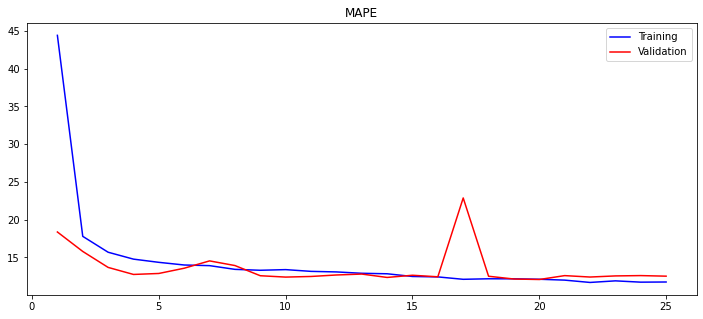

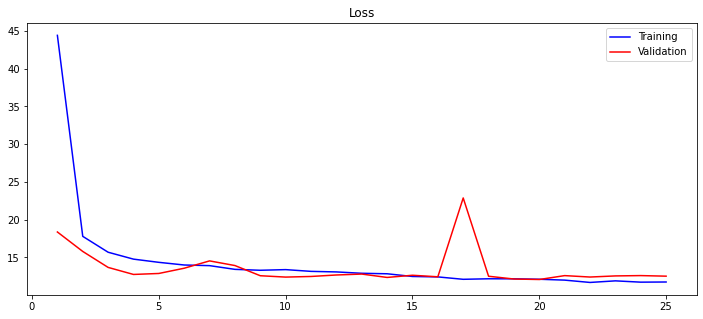

In [113]:
plot_history(history)

## Model evaluation

In [114]:
# Compile the model
model.compile(loss=LOSS_FUNC, metrics=[METRIC])

# Compute score
scores = model.evaluate(img_valid_dataset.batch(32))
print(f'Validation loss: %.2f %%' % scores[0])
print(f'Validation {METRIC}: %.2f %%' % scores[1])

42/42 [==============================] - 10s 110ms/step - loss: 11.5502 - MAPE: 11.5502
Validation loss: 12.07 %
Validation MAPE: 12.07 %


# Stacking

In [115]:
def compute_meta_feature(estimator, X_train, X_test, y_train, cv):
    """
    Эта функция подсчитывает признаки для мета-классификатора.
    
    :arg estimator: модель регрессии
    :args X_train, y_train: обучающая выборка
    :arg X_test: признаки тестовой выборки
    :arg cv: класс, генерирующий фолды (KFold)
    
    :returns X_meta_train, X_meta_test: новые признаки для обучающей и тестовой выборок
    """
    X_meta_train = np.zeros(len(y_train), dtype=np.float32)

    for train_fold_index, predict_fold_index in cv.split(X_train, y_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_estimator = clone(estimator)
        folded_estimator.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_estimator.predict(X_fold_predict)
    
    meta_estimator = clone(estimator)
    meta_estimator.fit(X_train, y_train)
    
    X_meta_test = meta_estimator.predict(X_test)
    
    return X_meta_train, X_meta_test


def compute_meta_feature_mean(estimator, X_train, X_test, y_train, cv):
    """
    Эта функция подсчитывает признаки для мета-классификатора.
    
    :arg estimator: модель регрессии
    :args X_train, y_train: обучающая выборка
    :arg X_test: признаки тестовой выборки
    :arg cv: класс, генерирующий фолды (KFold)
    
    :returns X_meta_train, X_meta_test: новые признаки для обучающей и тестовой выборок
    """
    X_meta_train = np.zeros(len(X_train), dtype=np.float32)
    X_meta_test = np.zeros(len(X_test), dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_estimator = clone(estimator)
        folded_estimator.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_estimator.predict(X_fold_predict)
        X_meta_test += folded_estimator.predict(X_test)

    X_meta_test /= cv.get_n_splits()

    return X_meta_train, X_meta_test


def generate_meta_features(estimators, X_train, X_test, y_train, cv):
    """Generate features for meta model"""
    features = [
        compute_meta_feature(estimator, X_train, X_test, y_train, cv)
            for estimator in tqdm(estimators)
    ]
    
    stacked_features_train = np.stack([
        features_train for features_train, features_test in features
    ]).T

    stacked_features_test = np.stack([
        features_test for features_train, features_test in features
    ]).T
    
    stacked_features_train = StandardScaler().fit_transform(stacked_features_train)
    stacked_features_test = StandardScaler().fit_transform(stacked_features_test)

    return stacked_features_train, stacked_features_test


def compute_metric(estimator, X_train, y_train, X_test, y_test):
    """Compute stack metric"""
    estimator.fit(X_train, y_train)
    score = np.mean(np.abs((y_test - estimator.predict(X_test)) / y_test))
    
    return score

In [116]:
# usefull_cols = [
# ]

# # Define cross validation
# n_splits = 10
# if PROBLEM == 'Regression':
#     cv = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
# elif PROBLEM == 'Classification':
#     cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

# stacked_features_train, stacked_features_valid = generate_meta_features([
#     RandomForestRegressor(n_estimators=100, criterion='mae', max_depth=10,
#                           max_features='sqrt', random_state=RANDOM_SEED,
#                           n_jobs=-1, verbose=0),
#     GradientBoostingRegressor(n_estimators=100, random_state=RANDOM_SEED),
# ], X_train[usefull_cols].values, X_valid[usefull_cols].values, y_train, cv)

# model = LinearRegression(n_jobs=-1)
# compute_metric(model, stacked_features_train, y_train, stacked_features_valid, y_valid)

In [117]:
# X_train_ = df.loc[df[TRAIN], usefull_cols].values
# y_train_ = df.loc[df[TRAIN], TARGET].values
# X_test_ = df.loc[~df[TRAIN], usefull_cols].values

# # Define cross validation
# n_splits = 10
# if PROBLEM == 'Regression':
#     cv = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
# elif PROBLEM == 'Classification':
#     cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

# stacked_features_train, stacked_features_test = generate_meta_features([
#     RandomForestRegressor(n_estimators=100, criterion='mae', max_depth=10,
#                           max_features='sqrt', random_state=RANDOM_SEED,
#                           n_jobs=-1, verbose=0),
#     GradientBoostingRegressor(n_estimators=100, random_state=RANDOM_SEED),
# ], X_train_, X_test_, y_train_, cv)

In [118]:
# # Create and learn model (stacking data)
# model = LinearRegression(n_jobs=-1)
# model.fit(stacked_features_train, y_train_)

# Submission

Predict

In [119]:
# predict_submission = model.predict(X_test[usefull_cols])
# predict_submission = model.predict(stacked_features_test)
predict_submission = model.predict(img_test_dataset.batch(32))

Postprocess

In [120]:
# predict_submission_post = ((predict_submission/1000).round() * 1000).astype('int')
predict_submission_post = predict_submission
predict_submission_post

array([[ 374417.75],
       [2581564.  ],
       [ 780154.  ],
       ...,
       [1288025.6 ],
       [1036386.9 ],
       [1003478.  ]], dtype=float32)

Write result to submission file

In [121]:
# sample_submission = pd.DataFrame()
sample_submission[IDENT] = df.loc[~df[TRAIN], IDENT]
# sample_submission[IDENT] = df.loc[~df[TRAIN]].index
sample_submission[TARGET] = predict_submission_post
# sample_submission.reset_index(drop=True, inplace=True)
sample_submission.to_csv('submission.csv', index=False)
sample_submission

,sell_id,price
0,1099427284,3.744178e+05
1,1096405886,2.581564e+06
2,1100195294,7.801540e+05
3,1099827282,4.427657e+05
4,1100076198,2.731302e+06
...,...,...
1666,1099414488,9.696374e+05
1667,1099277058,2.660849e+06
1668,1098773964,1.288026e+06
1669,1098835932,1.036387e+06


In [122]:
# Clean PATH_TEMP
# shutil.rmtree(PATH_TEMP)